<a href="https://colab.research.google.com/github/josivan-lima/cyanobacteria-risk-classification-with-ML/blob/main/ML_water_quality_PC(V1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install geopandas -q
! pip install geemap -q
!pip install rasterio -q

import ee
import geemap
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='ee-remote-sensing-lg-sonic')
from ee.data import listOperations
from ee.imagecollection import image
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import geopandas as gpd
import datetime
import pandas as pd
import os
import numpy as np
from scipy import stats
from osgeo import gdal
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from osgeo import osr
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.isotonic import IsotonicRegression
import rasterio
import numpy.ma as ma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.5 MB/s eta 0:00:00
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, pl

In [ ]:
def addDate(image):
  date=image.get('system:time_start')
  dateBand = ee.Image.constant(date).rename('date')
  dateBand = dateBand.updateMask(image.select('B8').mask())
  return image.addBands(dateBand)

def iHP(image):
  return image.addBands(
    image.expression("B5 - (B4 + B6)/2", {
      'B6': image.select("B6"),
      'B5': image.select("B5"),
      'B4': image.select("B4")
    }).rename('HP')
  )

def i2B(image):
  return image.addBands(
    image.expression("B5/B4", {
      'B5': image.select("B5"),
      'B4': image.select("B4")
    }).rename('2B')
  )

def i3B(image):
  return image.addBands(
    image.expression("(1/B4 - 1/B5) * B6", {
      'B6': image.select("B6"),
      'B5': image.select("B5"),
      'B4': image.select("B4")
    }).rename('3B')
  )

def iE3B(image):
  return image.addBands(
    image.expression("(1/B4 - 1/B5) / (1/B6 - 1/B5)", {
      'B6': image.select("B6"),
      'B5': image.select("B5"),
      'B4': image.select("B4")
    }).rename('E3B')
  )

def iNDCI(image):
  return image.addBands(
    image.expression("(B5 - B4) / (B5 + B4)", {
      'B5': image.select("B5"),
      'B4': image.select("B4")
    }).rename('NDCI')
  )

def iSLOPE(image):
  return image.addBands(
    image.expression("(B5 - B4) / (705 - 665)", {
      'B5': image.select("B5"),
      'B4': image.select("B4")
    }).rename('SLOPE')
  )

def iBG(image):
  return image.addBands(
    image.expression("B2 / B3", {
      'B2': image.select("B2"),
      'B3': image.select("B3")
    }).rename('BG')
  )

def iRG(image):
  return image.addBands(
    image.expression("B4 / B3", {
      'B4': image.select("B4"),
      'B3': image.select("B3")
    }).rename('RG')
  )

def i2BSubB(image):
  return image.addBands(
    image.expression("B6 - B4", {
      'B6': image.select("B6"),
      'B4': image.select("B4")
    }).rename('2BSubB')
  )

def i2BSubA(image):
  return image.addBands(
    image.expression("B5-B4", {
      'B5': image.select("B5"),
      'B4': image.select("B4")
    }).rename('2BSubA')
  )

def i2BDivB(image):
  return image.addBands(
    image.expression("B6/B5", {
      'B6': image.select("B6"),
      'B5': image.select("B5")
    }).rename('2BDivB')
    #.copyProperties(image,['system:time_start'])
  )

def i2BSubedge(image):
  return image.addBands(
    image.expression("B6 - B5", {
      'B6': image.select("B6"),
      'B5': image.select("B5")
    }).rename('2BSubedge')
  )

def iSABI(image):
  return image.addBands(
    image.expression("(B8A - B4) / (B2 + B3)", {
      'B8A': image.select("B8A"),
      'B4': image.select("B4"),
      'B2': image.select("B2"),
      'B3': image.select("B3")
    }).rename('SABI')
  )

def iFLH(image):
  return image.addBands(
    image.expression("B3 - (B4 - (B2-B4))", {
      'B4': image.select("B4"),
      'B2': image.select("B2"),
      'B3': image.select("B3")
    }).rename('FLH')
  )

def iNDPhyl(image):
  return image.addBands(
    image.expression("(B6 - B4) / (B6 + B4)", {
      'B6': image.select("B6"),
      'B4': image.select("B4")
    }).rename('NDPhyl')
  )

def iNDPhyledge(image):
  return image.addBands(
    image.expression("(B6 - B5) / (B6 + B5)", {
      'B6': image.select("B6"),
      'B5': image.select("B5")
    }).rename('NDPhyledge')
  )

def iABDI(image):
  return image.addBands(
    image.expression("(B6 - B4 - (B8A - B4) * ((740-665)/(865-665))) - (B4 - 0.5 * B3)", {
      'B6': image.select("B6"),
      'B4': image.select("B4"),
      'B8A': image.select("B8A"),
      'B3': image.select("B3")
    }).rename('ABDI')
  )

def iFAI(image):
  return image.addBands(
    image.expression("B8 - (B4 + (B11 - B4) * ((842-665)/(1610-665)))", {
      'B8': image.select("B8"),
      'B4': image.select("B4"),
      'B11': image.select("B11")
    }).rename('FAI')
  )

def iAFAI(image):
  return image.addBands(
    image.expression("B8A - B4 + (B11 - B4)*0.5", {
      'B4': image.select("B4"),
      'B8A': image.select("B8A"),
      'B11': image.select("B11")
    }).rename('AFAI')
  )

def iMCI(image):
  return image.addBands(
    image.expression("(B6 - B5) - ((B4 - B5) * ((740 - 705) / (665 - 705)))", {
      'B6': image.select("B6"),
      'B5': image.select("B5"),
      'B4': image.select("B4")
    }).rename('MCI')
  )
def iCIgreen(image):
  return image.addBands(
    image.expression("(B3 * (B5 - B4)) - (B4 * (B5 - B3))", {
      'B3': image.select("B3"),
      'B5': image.select("B5"),
      'B4': image.select("B4")
    }).rename('CIgreen')
  )
def iCIred_edge(image):
  return image.addBands(
    image.expression("(B5 * (B7 - B6)) - (B6 * (B7 - B5))", {
      'B5': image.select("B5"),
      'B7': image.select("B7"),
      'B6': image.select("B6")
    }).rename('CIred_edge')
  )


**Machine Learning Models**

In [ ]:
def iso(X_train, Y_train, X_test):
  # Instanciar o classificador
  ir = IsotonicRegression()
  # Treinar o classificador
  ir.fit_transform(X_train, Y_train)
  # Fazer previsões
  y_pred = ir.predict(X_test)
  return y_pred

def RIDGE(X_train, Y_train, X_test):
  # Instanciar o classificador
  ridge = Ridge()
  # Treinar o classificador
  ridge.fit(X_train, Y_train)
  # Fazer previsões
  y_pred = ridge.predict(X_test)
  return y_pred

from sklearn.svm import SVR
def SVreg(X_train, Y_train, X_test):
  # Instanciar o classificador
  svr = SVR()
  # Treinar o classificador
  svr.fit(X_train, Y_train)
  # Fazer previsões
  y_pred = svr.predict(X_test)
  return y_pred

def KNN(X_train, Y_train, X_test):
  # Instanciar o classificador
  knn = KNeighborsRegressor()
  # Treinar o classificador
  knn.fit(X_train, Y_train)
  # Fazer previsões
  y_pred = knn.predict(X_test)
  return y_pred

def MLP(X_train, Y_train, X_test):
  # Instanciar o classificador
  mlp = MLPRegressor() #(max_iter=1000)
  # Treinar o classificador
  mlp.fit(X_train, Y_train)
  # Fazer previsões
  y_pred = mlp.predict(X_test)
  return y_pred

def RF(X_train, Y_train, X_test):
  # Instanciar o classificador
  forest = RandomForestRegressor()
  # Treinar o classificador
  forest.fit(X_train, Y_train)
  # Fazer previsões
  y_pred = forest.predict(X_test)
  return y_pred

def LASSO(X_train, Y_train, X_test):
  # Instanciar o classificador
  lasso = Lasso()
  # Treinar o classificador
  lasso.fit(X_train, Y_train)
  # Fazer previsões
  y_pred = lasso.predict(X_test)
  return y_pred

def GBR(X_train, Y_train, X_test):
  # Instanciar o classificador
  gb_regressor = GradientBoostingRegressor()
  # Treinar o classificador
  gb_regressor.fit(X_train, Y_train)
  # Fazer previsões
  y_pred = gb_regressor.predict(X_test)
  return y_pred

def ELASTIC(X_train, Y_train, X_test):
  # Instanciar o classificador
  elastic_net = ElasticNet() #(alpha=1, l1_ratio=0.5)
  # Treinar o classificador
  elastic_net.fit(X_train, Y_train)
  # Fazer previsões
  y_pred = elastic_net.predict(X_test)
  return y_pred

def LINEAR(X_train, Y_train, X_test):
  # Instanciar o classificador
  lr = LinearRegression()
  # Treinar o classificador
  lr.fit(X_train, Y_train)
  # Fazer previsões
  y_pred = lr.predict(X_test)
  return y_pred

def PCAfunc(X_train, X_test):
  pca = PCA(n_components=2)  # Escolha o número de componentes principais aqui
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)
  return X_train_pca, X_test_pca

def plot_fig(X_test, Y_test, Y_pred):
  rmse = mean_squared_error(Y_test, Y_pred, squared=False)
  r2 = r2_score(Y_test, Y_pred)
  fig, ax = plt.subplots(figsize=(20,10))
  x_ax = range(len(X_test))
  plt.plot(x_ax, Y_test, color="black", label="original")
  plt.plot(x_ax, Y_pred,'-.', color="red", label="predicte")
  ax.set_ylabel('Phycocyanin (μg/L)')
  plt.text(0.90, 0.99, f'RMSE: {rmse:.2f}\nR²: {r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', ha='right', )
  plt.legend()
  plt.show()


def VOTING(X_train, Y_train, X_test):
  # Crie instâncias dos modelos que deseja combinar (no exemplo, usamos Linear Regression, Decision Tree Regressor e Support Vector Regression)
  model1 = RandomForestRegressor()
  model2 = Lasso()#DecisionTreeRegressor()
  model3 = SVR()
  model4 = Ridge()
  # Crie uma instância do modelo Voting e especifique os modelos que deseja combinar
  voting = VotingRegressor(estimators=[('rf', model1), ('lasso', model2), ('svr', model3)])
  # Treine o modelo
  voting.fit(X_train, Y_train)
  # Faça previsões
  y_pred = voting.predict(X_test)
  func_voting = voting.estimators_
  return y_pred, func_voting, voting



**Geojson reading**

In [ ]:
mpc_pros = gpd.read_file('/content/drive/MyDrive/gee_colab/MPC_Pros_selected.geojson')
print(mpc_pros.head(10))

   fid  Station     Coutry            Project Health  Last Repor Status  \
0    1  PRO-95D  ARGENTINA  PUERTO FEDERACION     FC  2022-12-05     ON   
1    2  PRO-22C  ARGENTINA         LAGO ROQUE     FC  2022-04-05     ON   
2    3  PRO-18A  ARGENTINA         LAGO ROQUE     FC  2022-04-04    OFF   
3    4  PRO-25E    ARMENIA        KARAS WINES     PC  2023-03-14     ON   
4    5  PRO-60B  AUSTRALIA   ARROW ENERGY DAM     PC  2023-03-15     ON   
5    6  PRO-61B  AUSTRALIA          SPARE BOX     FC  2022-04-05    OFF   
6    7  PRO-49C  AUSTRALIA    SPRINGVALE MINE     PC  2023-03-14     ON   
7    8  PRO-50C  AUSTRALIA    SPRINGVALE MINE     FC  2022-09-01     ON   
8    9  PRO-22E     BRAZIL         RIO GUANDU     PC  2023-03-14     ON   
9   10  PRO-10E     BRAZIL         RIO GUANDU     PC  2023-03-14     ON   

    Latitude   Longitude                     geometry  
0 -30.991168  -57.915484  POINT (-57.91548 -30.99117)  
1 -31.373900  -64.436900  POINT (-64.43690 -31.37390)  
2     

**Featurecollection creation function**

In [ ]:
# Empty Collection to fill
ft = ee.FeatureCollection(ee.List([]))

def fill(img, ini):
  # type cast
  inift = ee.FeatureCollection(ini)

  # gets the values for the points in the current img
  #ft2 = img.reduceRegions(ee.FeatureCollection('users/lucasterres/buoy2'), ee.Reducer.first(),10)
  ft2 = img.reduceRegions(ee.FeatureCollection(fc_buoy), ee.Reducer.first(),10)
  # gets the date of the img
  date = img.date().format()

  # writes the date in each feature
  #def date(f):
   # return f.set("date", date)

  #ft3 = ft2.map(date)

  # merges the FeatureCollections
  return inift.merge(ft2)

# Iterates over the ImageCollection


#Map.addLayer(pixel_extracted)
#Map

**Function to convert featurecollection to dataframe**

In [ ]:
def fc2df(fc):
    # Convert a FeatureCollection into a pandas DataFrame
    # Features is a list of dict with the output
    features = fc.getInfo()['features']

    dictarr = []

    for f in features:
        # Store all attributes in a dict
        attr = f['properties']
        # and treat geometry separately
        attr['geometry'] = f['geometry']  # GeoJSON Feature!
        # attr['geometrytype'] = f['geometry']['type']
        dictarr.append(attr)

    df = gpd.GeoDataFrame(dictarr)
    # Convert GeoJSON features to shape
    #df['geometry'] = map(lambda s: shape(s), df.geometry)
    return df


**Image data extraction**

In [ ]:
list_feat = []
df_extracted = pd.DataFrame([])
for j in range(0, len(mpc_pros)):
#for j in range(0, 5):
  if np.isnan(mpc_pros['Latitude'][j]) == True or np.isnan(mpc_pros['Longitude'][j]) == True:
    #print(mpc_pros['Station'][j])
    pass
  else:
    #print(mpc_pros['Station'][j])
    list_feat = ee.Feature(ee.Geometry.Point(mpc_pros['Longitude'][j], mpc_pros['Latitude'][j]), {'Buoy': mpc_pros['Station'][j]})
    fc_buoy = ee.FeatureCollection(list_feat)
    fc_buoy.set({'crs':'EPSG:4326'})
    dataset = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                    .filterDate('2022-04-06', '2023-03-13')\
                    .filterBounds(fc_buoy)\
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',1))\
                    .map(iHP) \
                    .map(i2B) \
                    .map(i3B) \
                    .map(iE3B) \
                    .map(iNDCI) \
                    .map(iSLOPE) \
                    .map(iBG) \
                    .map(iRG) \
                    .map(i2BSubB) \
                    .map(i2BSubA) \
                    .map(i2BDivB) \
                    .map(i2BSubedge) \
                    .map(iSABI) \
                    .map(iFLH) \
                    .map(iNDPhyl) \
                    .map(iNDPhyledge) \
                    .map(iABDI) \
                    .map(iFAI) \
                    .map(iAFAI) \
                    .map(iCIred_edge)\
                    .map(iCIgreen)\
                    .map(iMCI)\
                    .map(addDate)
    pixel_extracted = ee.FeatureCollection(dataset.iterate(fill, ft ))
    df_extracted1 = fc2df(pixel_extracted)
    df_extracted = pd.concat([df_extracted,df_extracted1])
df_extracted['date'] = pd.to_datetime(df_extracted['date'], unit='ms')
df_extracted['date'] = df_extracted['date'].dt.strftime('%Y-%m-%d')
df_extracted = df_extracted.loc[:, ['date', 'Buoy', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '2B', '2BDivB', '2BSubA', '2BSubB', '2BSubedge', '3B', 'ABDI', 'AFAI', 'BG', 'E3B', 'FAI', 'FLH', 'HP', 'NDCI', 'NDPhyl', 'NDPhyledge', 'RG', 'SABI', 'SLOPE'	]]
#df_extracted = df_extracted.loc[:, ['date', 'Buoy', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '2B', '2BSubA', '2BSubB', '2BSubedge', '3B', 'E3B', 'FAI', 'FLH', 'HP', 'NDCI', 'RG', 'SLOPE'	]]


#df_extracted = df_extracted.loc[:, ['date', 'Buoy', 'B1', 'B2', 'B3', 'B5', 'B8A', '2B', '2BSubA', 'ABDI', 'AFAI', 'BG', 'E3B', 'FAI', 'FLH', 'HP', 'NDCI', 'RG', 'SABI'	]]
#df_extracted = df_extracted.loc[:, ['date', 'Buoy', 'B4', 'B8', '2B', 'NDCI', 'RG', 'SABI', 'SLOPE'	]]

#df_extracted['Buoy'] = df_extracted['Buoy'].astype(str)
df_extracted.head(10)
df_extracted


,date,Buoy,B1,B2,B3,B4,B5,B6,B7,B8,...,E3B,FAI,FLH,HP,NDCI,NDPhyl,NDPhyledge,RG,SABI,SLOPE
0,2022-04-13,PRO-95D,181,327,558,392,553,243,229,224,...,0.321947,-113.307937,101,235.5,0.170370,-0.234646,-0.389447,0.702509,-0.292655,4.025
1,2022-04-18,PRO-95D,289,410,762,737,832,358,360,296,...,0.097356,-327.120635,-302,284.5,0.060548,-0.346119,-0.398319,0.967192,-0.446246,2.375
2,2022-05-08,PRO-95D,199,272,478,520,487,220,222,211,...,-0.052290,-229.584127,-290,117.0,-0.032771,-0.405405,-0.377652,1.087866,-0.489333,-0.825
3,2022-06-12,PRO-95D,268,477,865,986,1040,420,394,342,...,0.037100,-478.612698,-630,337.0,0.026654,-0.402560,-0.424658,1.139884,-0.572280,1.350
4,2022-07-17,PRO-95D,223,338,672,718,706,273,276,223,...,-0.010537,-375.876190,-426,210.5,-0.008427,-0.449041,-0.442288,1.068452,-0.544554,-0.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,2023-02-19,PRO-04A,157,196,358,214,282,150,153,138,...,0.361088,-65.136508,126,100.0,0.137097,-0.175824,-0.305556,0.597765,-0.135379,1.700
44,2023-02-27,PRO-04A,108,223,380,225,279,159,205,168,...,0.318000,-47.634921,153,87.0,0.107143,-0.171875,-0.273973,0.592105,-0.106136,1.350
45,2023-03-06,PRO-04A,90,207,320,172,243,98,149,112,...,0.278990,-51.009524,183,108.0,0.171084,-0.274074,-0.425220,0.537500,-0.091082,1.775
46,2023-03-09,PRO-04A,98,217,460,219,383,172,228,168,...,0.610444,-40.136508,239,187.5,0.272425,-0.120205,-0.380180,0.476087,-0.094535,4.100


In [ ]:
# Add all images in collection as layers
listOfImages = dataset.toList(dataset.size())
number_images = dataset.size().getInfo()
for indx in  range(0, number_images):
  img = ee.Image(listOfImages.get(indx))
  mndwi = img.normalizedDifference(["B3", "B6"]).rename("mndwi")
  water = mndwi.gt(-0.1).selfMask()
  filterselectRGB = ee.ImageCollection(img).select(['B2', 'B3', 'B4'])
  filteRGB  = filterselectRGB.reduce(ee.Reducer.median())
  filtermaskRGB = filteRGB.updateMask(water)

visParams = {
  'bands': ['B4_median', 'B3_median', 'B2_median'],
  'min': 0,
  'max': 5000
}

# client side loop
for i in range(0, number_images, 1):
  image = ee.Image(listOfImages.get(i))
  #Map.addLayer(image.clip(roi), visParams, str(i), 0)

#Add the buoys
VisBuoy = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 5000
}
Map = geemap.Map()
#Map.addLayer(filtermaskRGB, visParams, 'Lake')
Map.addLayer(fc_buoy)
print(number_images)
Map

**Data processing**

In [ ]:
directory = '/content/drive/MyDrive/gee_colab/'
files = os.listdir(directory)

in_situ_all = pd.DataFrame()
for f in range(len(files)):
  #in_situ = pd.read_excel('/content/drive/MyDrive/gee_colab/combined_algae_indicator.xlsx', skiprows=[0])
  in_situ = pd.read_excel('/content/drive/MyDrive/gee_colab/cleaned_combined_algae_indicator4.xlsx')
  cols = ["Chlorophyll","Phycocyanin","Turbidity"]
  in_situ[cols] = in_situ[cols].replace({'0':np.nan, 0:np.nan})
  in_situ['Timestamp'] = pd.to_datetime(in_situ['Timestamp'])
  in_situ['Timestamp'] = in_situ['Timestamp'].dt.strftime('%Y-%m-%d')
  #in_situ = in_situ.loc[in_situ['Timestamp'].isin('11:00', '11:15', '11:30', '11:45', '12:00','12:15', '12:30', '12:45', '13:00' )] #change accordingly if there are enough measurements
  in_situ.columns = ['date', 'Buoy', 'chla', 'PC', 'Turb']
  in_situ_all = in_situ_all.append(in_situ)


in_situ_all = in_situ_all.groupby(['date', 'Buoy']).mean()
in_situ_all = in_situ_all.reset_index(drop=False)
in_situ_all.columns = ['date', 'Buoy', 'chla', 'PC', 'Turb']
print(in_situ_all.head())
print(in_situ_all.tail())

<ipython-input-8-43d644021654>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  in_situ_all = in_situ_all.append(in_situ)
<ipython-input-8-43d644021654>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  in_situ_all = in_situ_all.append(in_situ)
<ipython-input-8-43d644021654>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  in_situ_all = in_situ_all.append(in_situ)
<ipython-input-8-43d644021654>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  in_situ_all = in_situ_all.append(in_situ)
<ipython-input-8-43d644021654>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

         date             Buoy     chla         PC       Turb
0  2022-04-05  Cell 1 /PRO-70D    2.206   0.456000    2.61300
1  2022-04-05  Cell 2 /PRO-72D      NaN        NaN    3.25980
2  2022-04-05  Cell 3 /PRO-71D  137.074        NaN   11.32775
3  2022-04-05          PRO-04A   22.025  34.340000  233.87000
4  2022-04-05          PRO-04C    4.323  10.882333    2.34600
             date     Buoy       chla        PC       Turb
22759  2023-03-17  PRO-87D   3.817593  1.094400   0.574962
22760  2023-03-17  PRO-88B  13.465086       NaN        NaN
22761  2023-03-17  PRO-92B   4.738761  1.774756  24.870404
22762  2023-03-17  PRO-93B   3.734930  2.052410  29.565326
22763  2023-03-17  PRO-97E  54.643023  1.903325   9.281042


**Data merge**

In [ ]:
df_merged = pd.merge(df_extracted,in_situ_all, on=['date', 'Buoy'], how='inner' )

#drop repeated rows
#df_merged = df_merged.drop_duplicates(subset=['Buoy', 'date'])
#df_merged.rename( columns={'Chlorophyll-a (µg/L)':'chla', 'Phycocyanin (µg/L)': 'PC', 'Turbidity (FNU)':'Turb'}, inplace=True )
df_merged

,date,Buoy,B1,B2,B3,B4,B5,B6,B7,B8,...,HP,NDCI,NDPhyl,NDPhyledge,RG,SABI,SLOPE,chla,PC,Turb
0,2022-05-08,PRO-95D,199,272,478,520,487,220,222,211,...,117.0,-0.032771,-0.405405,-0.377652,1.087866,-0.489333,-0.825,9.951833,7.806750,11.621667
1,2022-11-24,PRO-95D,463,432,738,535,475,258,283,260,...,78.5,-0.059406,-0.349306,-0.296044,0.724932,-0.265812,-1.500,45.091687,141.407532,42.260938
2,2022-11-29,PRO-95D,682,776,1088,754,1048,689,702,598,...,326.5,0.163152,-0.045045,-0.206678,0.693015,-0.086373,7.350,36.046809,194.809745,44.504298
3,2022-09-11,PRO-25E,317,556,885,628,1112,617,654,523,...,489.5,0.278161,-0.008835,-0.286293,0.709605,-0.174879,12.100,22.914500,NaN,80.130429
4,2022-09-13,PRO-25E,205,425,866,545,1100,515,518,427,...,570.0,0.337386,-0.028302,-0.362229,0.629330,-0.173509,13.875,15.382364,NaN,76.083674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,2022-12-31,PRO-04A,333,354,619,347,430,223,230,239,...,145.0,0.106821,-0.217544,-0.316998,0.560582,-0.155190,2.075,132.453571,227.235048,76.080860
872,2023-01-05,PRO-04A,136,225,468,229,397,147,184,182,...,209.0,0.268371,-0.218085,-0.459559,0.489316,-0.128427,4.200,95.472917,330.966917,182.913583
873,2023-01-15,PRO-04A,116,163,366,178,353,122,155,143,...,203.0,0.329567,-0.186667,-0.486316,0.486339,-0.143667,4.375,33.113000,402.097000,12.446333
874,2023-01-30,PRO-04A,58,120,390,185,346,102,140,115,...,202.5,0.303202,-0.289199,-0.544643,0.474359,-0.192157,4.025,59.754000,343.174000,18.575000


In [ ]:
import seaborn as sns
"""df_merge = df_merged.loc[:, ['PC', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '2B',\
                  '2BDivB', '2BSubA', '2BSubB', '2BSubedge', '3B', 'ABDI', 'AFAI',\
                  'BG', 'E3B', 'FAI', 'FLH', 'HP', 'NDCI', 'NDPhyl', 'NDPhyledge', \
                  'RG', 'SABI', 'SLOPE']]


df_merge = df_merged.loc[:, ['PC', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'RBratio']]"""
df_merge = df_merged.loc[:, ['PC', '2B', '2BSubA', '2BSubB', '3B', 'AFAI', 'HP', 'NDCI', 'NDPhyl', 'SLOPE']]

# Crie uma matriz de correlação
correlation_matrix = df_merge.corr()

# Configure o estilo do seaborn
sns.set(style="white")

# Crie um objeto de plotagem
plt.figure(figsize=(10, 8))

# Gere um mapa de calor (heatmap) da matriz de correlação
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)

# Defina o título do gráfico
plt.title("Correlograma")

# Exiba o gráfico
plt.show()

NameError: name 'df_merged' is not defined

**Filter to remove outliers**

In [ ]:
df_merged = df_merged.drop(df_merged[df_merged['PC'] >= 150].index)
df_merged

,date,Buoy,B1,B2,B3,B4,B5,B6,B7,B8,...,HP,NDCI,NDPhyl,NDPhyledge,RG,SABI,SLOPE,chla,PC,Turb
0,2022-05-08,PRO-95D,199,272,478,520,487,220,222,211,...,117.0,-0.032771,-0.405405,-0.377652,1.087866,-0.489333,-0.825,9.951833,7.806750,11.621667
1,2022-11-24,PRO-95D,463,432,738,535,475,258,283,260,...,78.5,-0.059406,-0.349306,-0.296044,0.724932,-0.265812,-1.500,45.091687,141.407532,42.260938
18,2022-05-04,PRO-60B,160,251,457,256,380,130,148,107,...,187.0,0.194969,-0.326425,-0.490196,0.560175,-0.224576,3.100,27.069062,16.575875,NaN
19,2022-05-17,PRO-60B,149,254,451,281,408,100,122,79,...,217.5,0.184325,-0.475066,-0.606299,0.623060,-0.323404,3.175,28.774778,8.987143,NaN
20,2022-06-13,PRO-60B,186,319,550,317,373,86,107,81,...,171.5,0.081159,-0.573201,-0.625272,0.576364,-0.295742,1.400,35.037167,22.408687,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,2022-10-27,PRO-04A,208,326,508,352,357,228,261,235,...,67.0,0.007052,-0.213793,-0.220513,0.692913,-0.179856,0.125,65.454512,99.209875,17.714900
859,2022-11-04,PRO-04A,709,718,932,808,809,661,676,640,...,74.5,0.000618,-0.100068,-0.100680,0.866953,-0.096364,0.025,8.944605,12.209405,7.777184
860,2022-11-09,PRO-04A,834,796,1015,890,905,746,803,698,...,87.0,0.008357,-0.088020,-0.096305,0.876847,-0.070679,0.375,21.416350,14.001450,12.409342
861,2022-11-16,PRO-04A,164,240,420,231,226,114,154,146,...,53.5,-0.010941,-0.339130,-0.329412,0.550000,-0.136364,-0.125,39.474629,16.659361,43.847000


**Definition of dependent and independent variables**

In [ ]:
df_merged.drop(df_merged[np.isnan(df_merged['PC'])].index, inplace = True)

label = df_merged['PC'] #Aqui é possível definir outra variável dependente
print(label)
data = df_merged[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '2B', '2BDivB', '2BSubA', '2BSubB', '2BSubedge', '3B', 'ABDI', 'AFAI', 'BG', 'E3B', 'FAI', 'FLH', 'HP', 'NDCI', 'NDPhyl', 'NDPhyledge', 'RG', 'SABI', 'SLOPE']]
#data = df_merged[[ '2B', '2BSubA', '2BSubB', '3B', 'AFAI', 'HP', 'NDCI', 'NDPhyl', 'SLOPE']]

data

0        7.806750
1      141.407532
18      16.575875
19       8.987143
20      22.408687
          ...    
858     99.209875
859     12.209405
860     14.001450
861     16.659361
867    112.216825
Name: PC, Length: 739, dtype: float64


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,2B,...,E3B,FAI,FLH,HP,NDCI,NDPhyl,NDPhyledge,RG,SABI,SLOPE
0,199,272,478,520,487,220,222,211,153,0.936538,...,-0.052290,-229.584127,-290,117.0,-0.032771,-0.405405,-0.377652,1.087866,-0.489333,-0.825
1,463,432,738,535,475,258,283,260,224,0.887850,...,-0.133339,-217.123810,100,78.5,-0.059406,-0.349306,-0.296044,0.724932,-0.265812,-1.500
18,160,251,457,256,380,130,148,107,97,1.484375,...,0.251875,-119.406349,196,187.0,0.194969,-0.326425,-0.490196,0.560175,-0.224576,3.100
19,149,254,451,281,408,100,122,79,53,1.451957,...,0.146739,-160.980952,143,217.5,0.184325,-0.475066,-0.606299,0.623060,-0.323404,3.175
20,186,319,550,317,373,86,107,81,60,1.176656,...,0.052935,-188.987302,235,171.5,0.081159,-0.573201,-0.625272,0.576364,-0.295742,1.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,208,326,508,352,357,228,261,235,202,1.014205,...,0.025106,-93.774603,130,67.0,0.007052,-0.213793,-0.220513,0.692913,-0.179856,0.125
859,709,718,932,808,809,661,676,640,649,1.001238,...,0.005527,-133.349206,34,74.5,0.000618,-0.100068,-0.100680,0.866953,-0.096364,0.025
860,834,796,1015,890,905,746,803,698,762,1.016854,...,0.079076,-156.600000,31,87.0,0.008357,-0.088020,-0.096305,0.876847,-0.070679,0.375
861,164,240,420,231,226,114,154,146,141,0.978355,...,-0.022032,-70.203175,198,53.5,-0.010941,-0.339130,-0.329412,0.550000,-0.136364,-0.125


**Splitting and standardizing data**

In [ ]:
#data = df_merged[['B5', 'B6', 'B7', 'B8', 'B8A', '2BSubB', 'ABDI',]]
#data = df_merged[['B8']] para a isotônica
x = data

scaler = StandardScaler()

# Padronize os dados
x = pd.DataFrame(scaler.fit_transform(x), columns=data.columns)
y = label
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.1, random_state=42)
print(X_train)

           B1        B2        B3        B4        B5        B6        B7  \
49   0.383609  0.281755  0.419353  0.309006  0.120722 -0.175980 -0.170042   
344 -0.656685 -0.389345 -0.412569 -0.313105 -0.359891 -0.295322 -0.297473   
118  0.728859  0.453193  0.203493 -0.107086 -0.157075 -0.128004 -0.141267   
196 -0.436361 -0.358574 -0.012368 -0.271902 -0.158919 -0.328905 -0.339754   
507 -0.629429 -0.568109 -0.583538 -0.418479 -0.452695 -0.418261 -0.426079   
..        ...       ...       ...       ...       ...       ...       ...   
71  -0.263736 -0.138781 -0.251151 -0.262445 -0.324245 -0.267135 -0.281618   
106  0.722045  0.464915  0.226416 -0.115867 -0.225910 -0.223957 -0.217608   
270  2.848061  3.144917  3.296220  3.320944  3.395896  3.347295  3.329329   
435 -0.858838 -0.716103 -0.661859 -0.461034 -0.479123 -0.418261 -0.426079   
102  0.572134  0.587999  0.205403 -0.001712 -0.075949 -0.029652 -0.037325   

           B8       B8A        2B  ...       E3B       FAI       FLH  \
49 

In [ ]:
def VOTING(X_train, Y_train, X_test):
  # Crie instâncias dos modelos que deseja combinar (no exemplo, usamos Linear Regression, Decision Tree Regressor e Support Vector Regression)
  model1 = RandomForestRegressor()
  model2 = Lasso()#DecisionTreeRegressor()
  model3 = SVR()
  model4 = Ridge()
  model5 = ElasticNet()
  # Crie uma instância do modelo Voting e especifique os modelos que deseja combinar
  voting = VotingRegressor(estimators=[('rf', model1), ('lasso', model2), ('svr', model3), ('elastic', model5)])
  # Treine o modelo
  voting.fit(X_train, Y_train)
  # Faça previsões
  y_pred = voting.predict(X_test)
  func_voting = voting.estimators_
  return y_pred, func_voting, voting

MSE: 450.49583824719554
RMSE: 21.22488723756137
R²: 0.5780477971450477


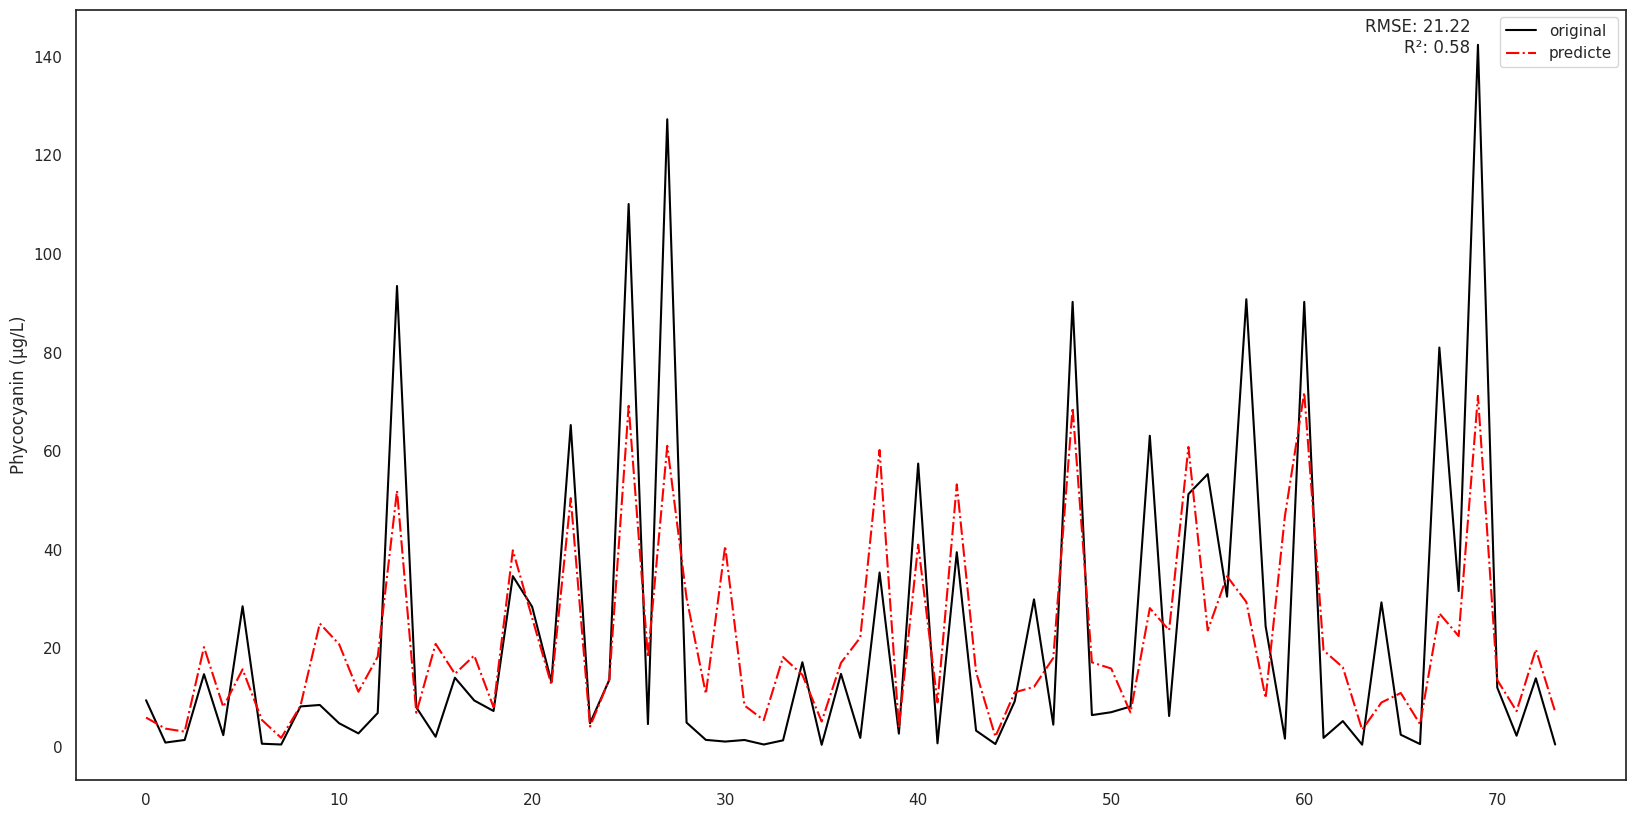

In [ ]:
voting_pred, function, model = VOTING(X_train, Y_train, X_test)

# Calcular o MSE
mse = mean_squared_error(Y_test, voting_pred)
print("MSE:", mse)

rmse = mean_squared_error(Y_test, voting_pred, squared=False)
print("RMSE:", rmse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, voting_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, voting_pred)


In [ ]:
# Calcular os resíduos
residuals = Y_test - voting_pred
# Histograma dos resíduos
plt.hist(residuals, bins='auto')
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.title("Histograma dos Resíduos")
plt.show()


In [ ]:
plt.scatter(voting_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Linha de referência zero
plt.xlabel("Previsões")
plt.ylabel("Resíduos")
plt.title("Gráfico de Dispersão dos Resíduos")
plt.show()

In [ ]:
plt.scatter(Y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Linha de referência zero
plt.xlabel("Valores reais")
plt.ylabel("Resíduos")
plt.title("Gráfico de Dispersão dos Resíduos")
plt.show()

In [ ]:
coefs = np.polyfit(voting_pred, Y_test, 1)
poly = np.poly1d(coefs)

# Plotando o gráfico de dispersão dos dados
plt.scatter(voting_pred, Y_test, label='Dados')

# Plotando a linha de regressão
plt.plot(voting_pred, poly(voting_pred), color='red', label='Regressão')

# Adicionando rótulos e título
plt.xlabel('Predicte')
plt.ylabel('Original')
plt.title('Gráfico de Regressão')
plt.legend()
plt.show()

MSE: 468.83909344144104
RMSE: 21.65269252174983
R²: 0.5608667795204291


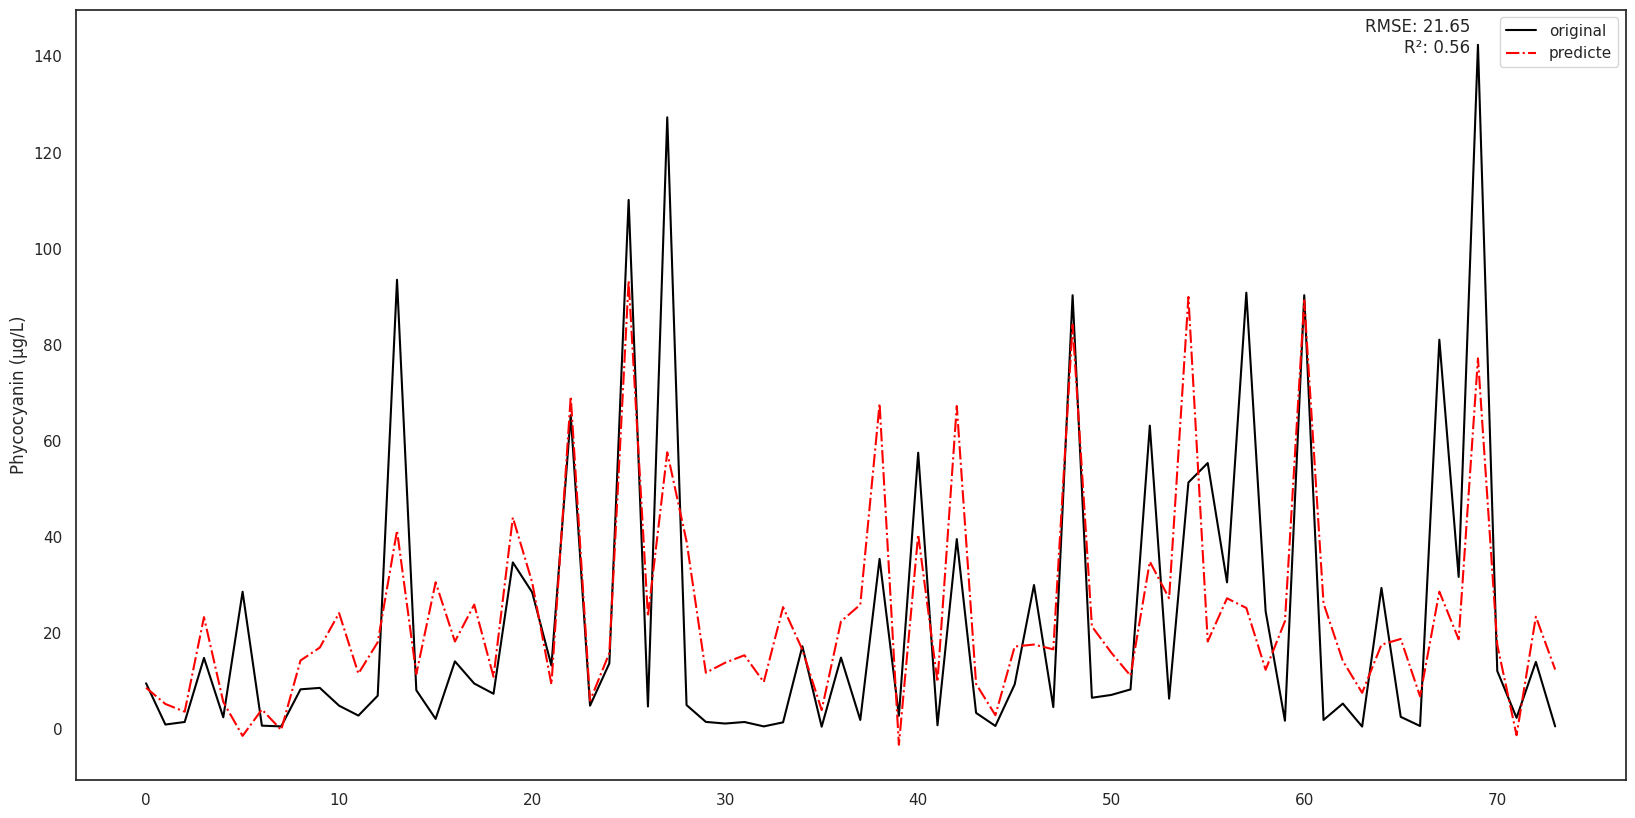

In [ ]:
from sklearn.linear_model import BayesianRidge
# Criar uma instância do modelo BayesianRidge
modelo = BayesianRidge()

# Treinar o modelo com os dados de treinamento
modelo.fit(X_train, Y_train)

# Fazer previsões para os dados de teste
y_pred = modelo.predict(X_test)

# Calcular métricas como MSE, RMSE e R²
mse = mean_squared_error(Y_test, y_pred)
rmse = mean_squared_error(Y_test, y_pred, squared=False)
r2 = r2_score(Y_test, y_pred)

# Imprimir as métricas
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

plot_fig(X_test, Y_test, y_pred)

In [ ]:
IR_pred = iso(X_train, Y_train, X_test)

# Calcular o MSE
mse = mean_squared_error(Y_test, IR_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, IR_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, IR_pred)

Linear Regression

MSE: 448.27673914868797
R²: 0.5801262930455025


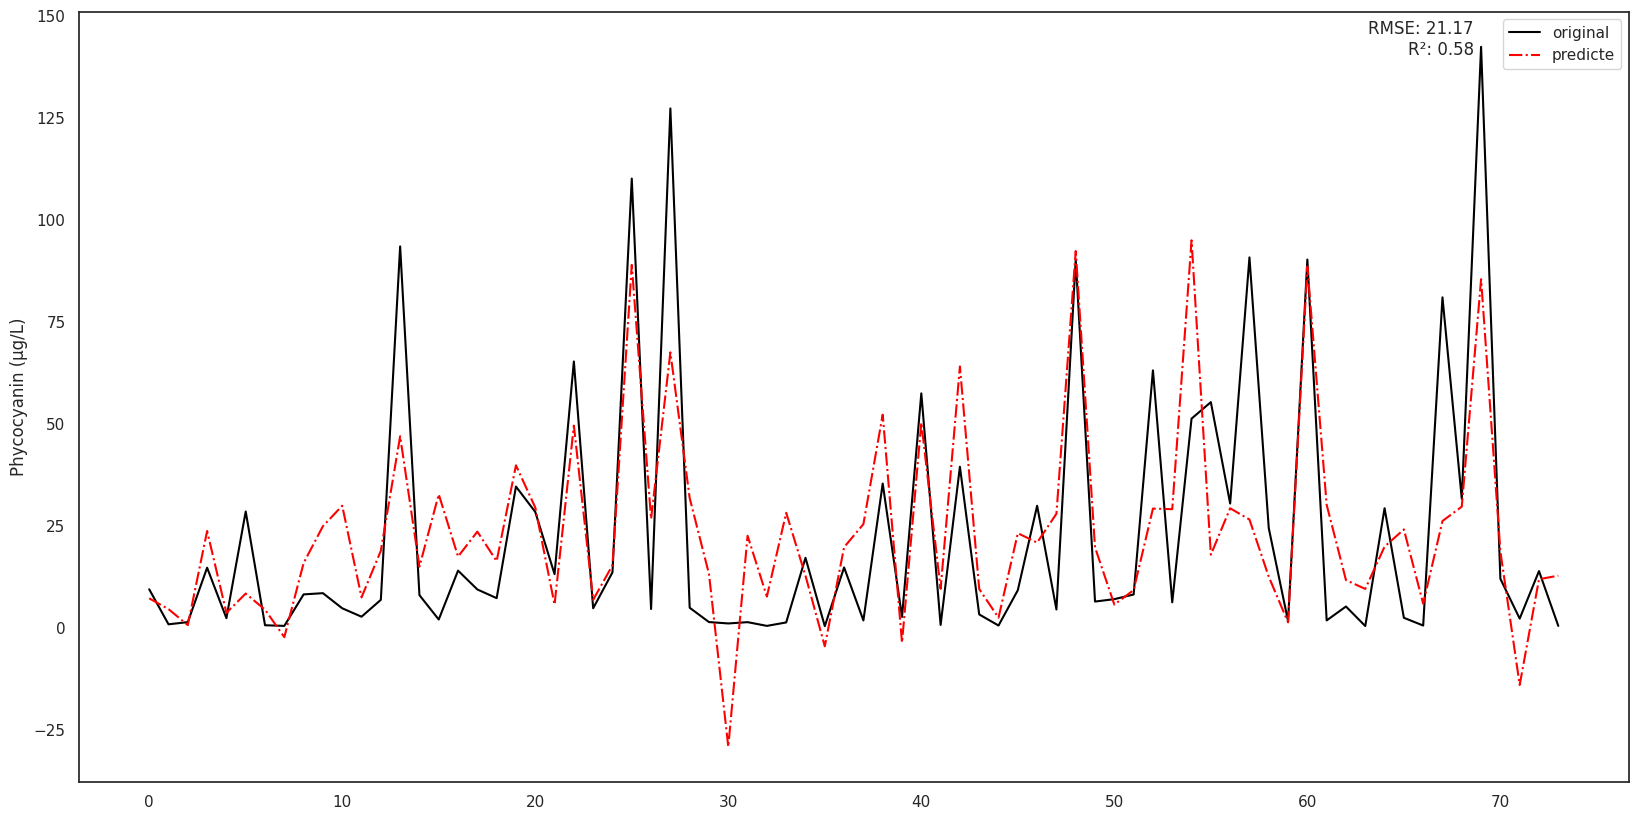

In [ ]:
LR_pred = LINEAR(X_train, Y_train, X_test)

# Calcular o MSE
mse = mean_squared_error(Y_test, LR_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, LR_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, LR_pred)

PCA + Linear Regression

In [ ]:
X_train_pca, X_test_pca = PCAfunc(X_train, X_test)
LR_pred = LINEAR(X_train_pca, Y_train, X_test_pca)

# Calcular o MSE
mse = mean_squared_error(Y_test, LR_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, LR_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, LR_pred)

ElasticNet Regression

MSE: 552.0805262916847
R²: 0.48289956433676795


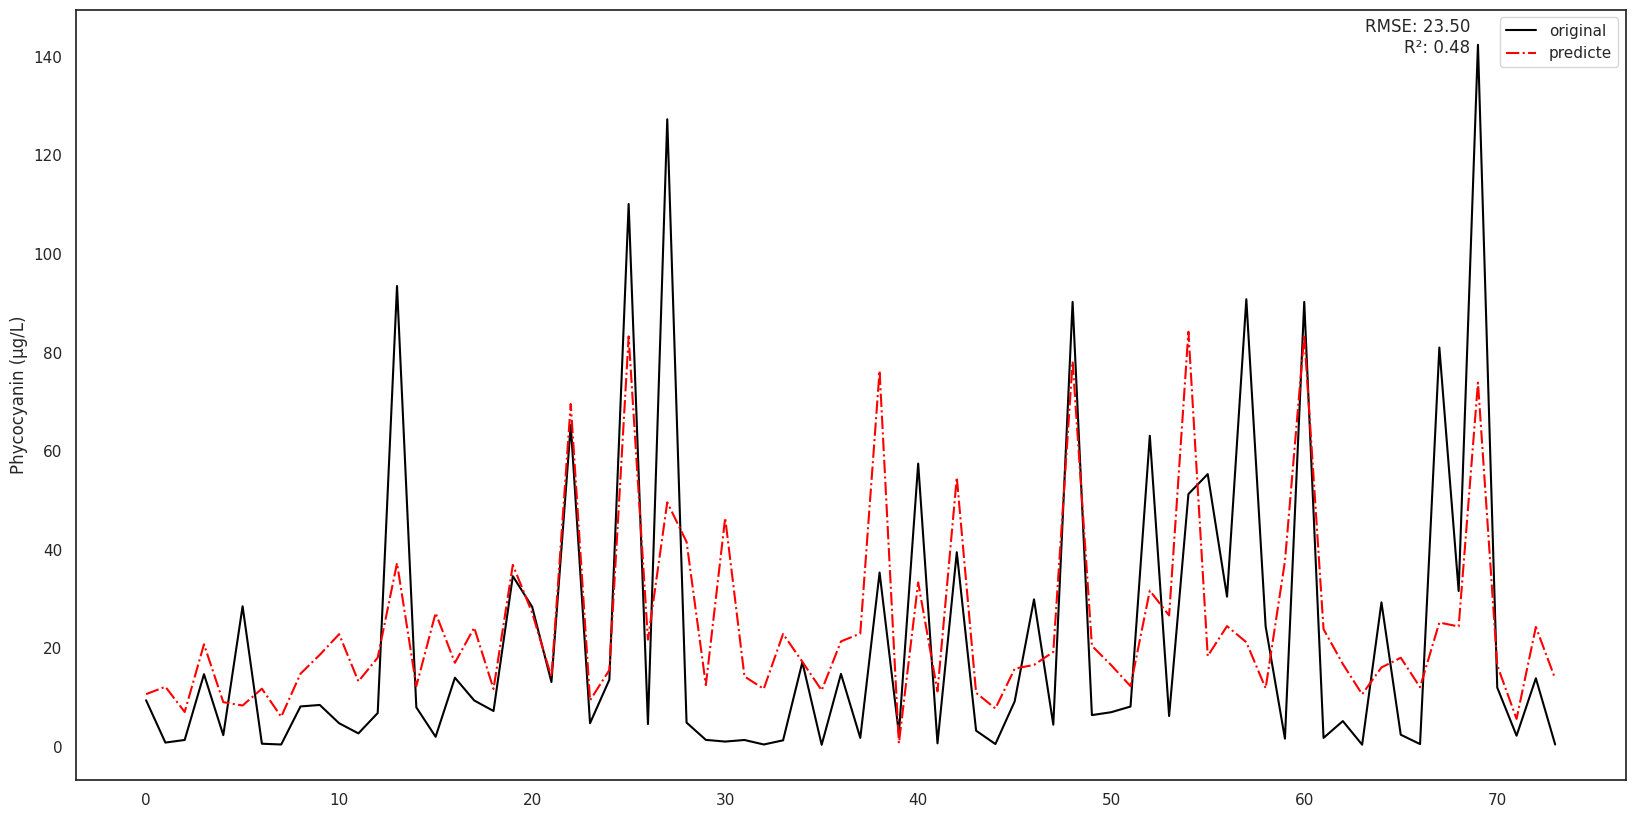

In [ ]:
elastic_pred = ELASTIC(X_train, Y_train, X_test)

# Calcular o MSE
mse = mean_squared_error(Y_test, elastic_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, elastic_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, elastic_pred)

PCA + ElasticNet Regression

In [ ]:
X_train_pca, X_test_pca = PCAfunc(X_train, X_test)
elastic_pred = ELASTIC(X_train_pca, Y_train, X_test_pca)

# Calcular o MSE
mse = mean_squared_error(Y_test, elastic_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, elastic_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, elastic_pred)

 Gradient Boosting Regressor

MSE: 384.2267830203813
R²: 0.6401180128053471


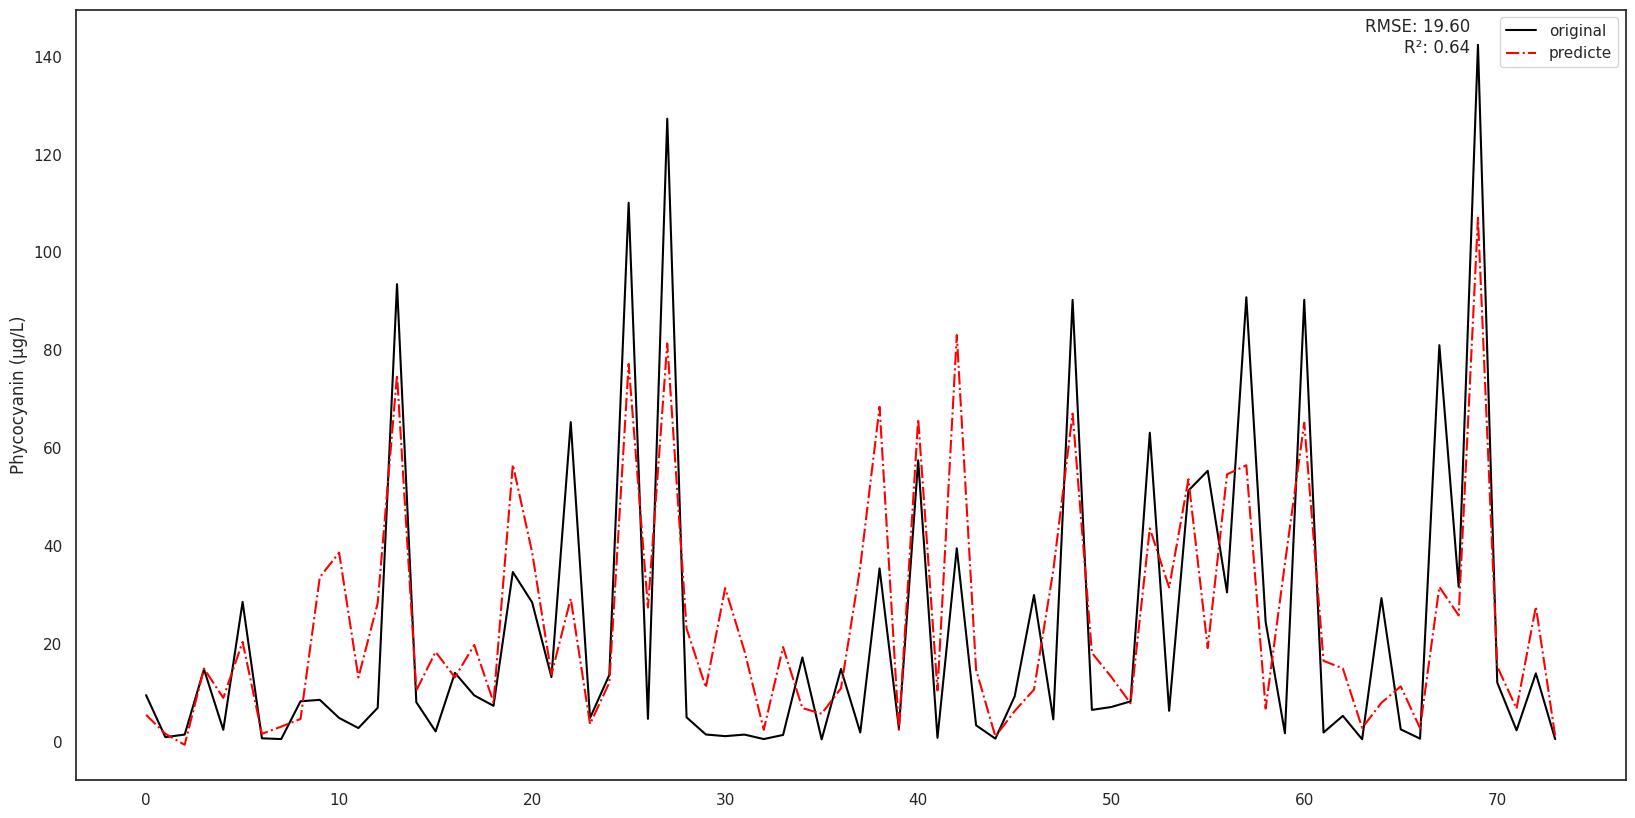

In [ ]:
GB_pred = GBR(X_train, Y_train, X_test)

# Calcular o MSE
mse = mean_squared_error(Y_test, GB_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, GB_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, GB_pred)

PCA + Gradient Boosting Regressor

MSE: 623.9433952804911
R²: 0.41558996167476714


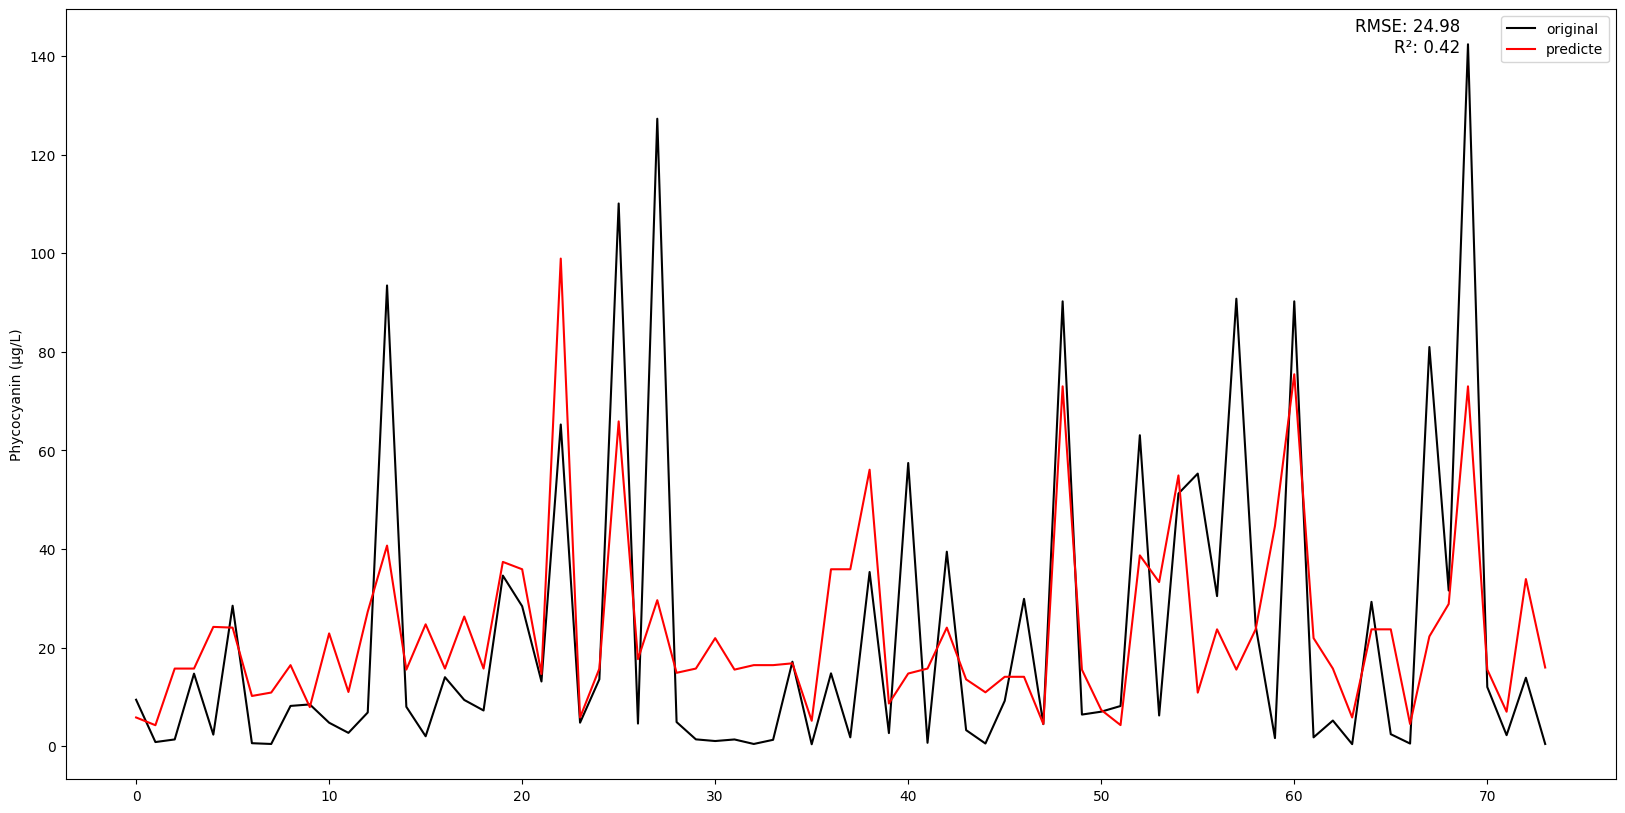

In [ ]:
X_train_pca, X_test_pca = PCAfunc(X_train, X_test)
GB_pred = GBR(X_train_pca, Y_train, X_test_pca)

# Calcular o MSE
mse = mean_squared_error(Y_test, GB_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, GB_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, GB_pred)

Random Forest

MSE: 422.8896780019483
R²: 0.6039048176519878


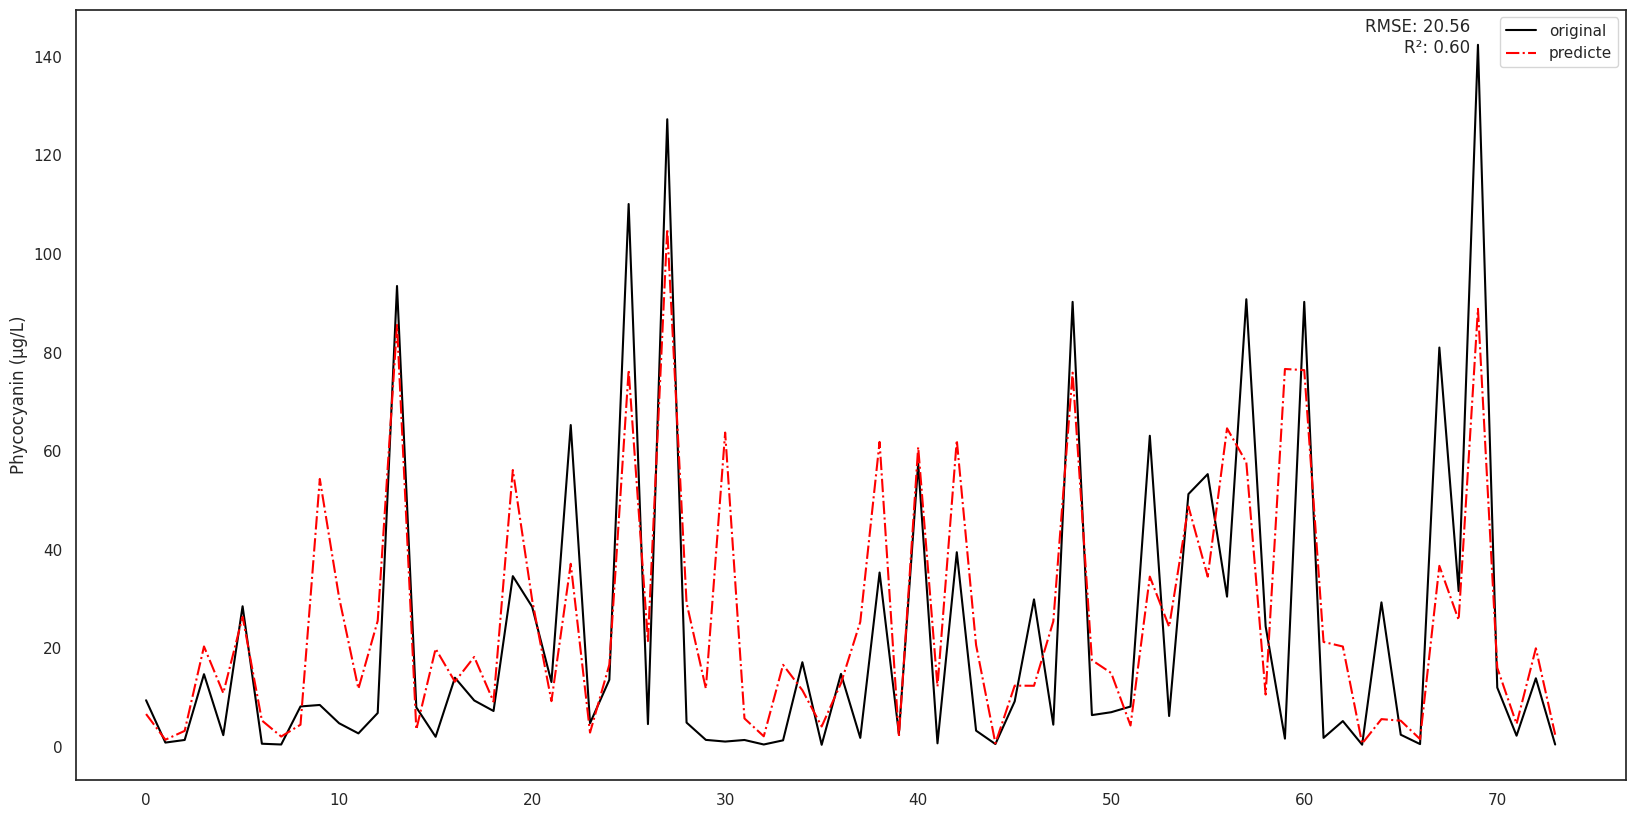

In [ ]:
RF_pred = RF(X_train, Y_train, X_test)

# Calcular o MSE
mse = mean_squared_error(Y_test, RF_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, RF_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, RF_pred)

PCA + Random Forest

MSE: 715.9613157650492
R²: 0.3294023413814007


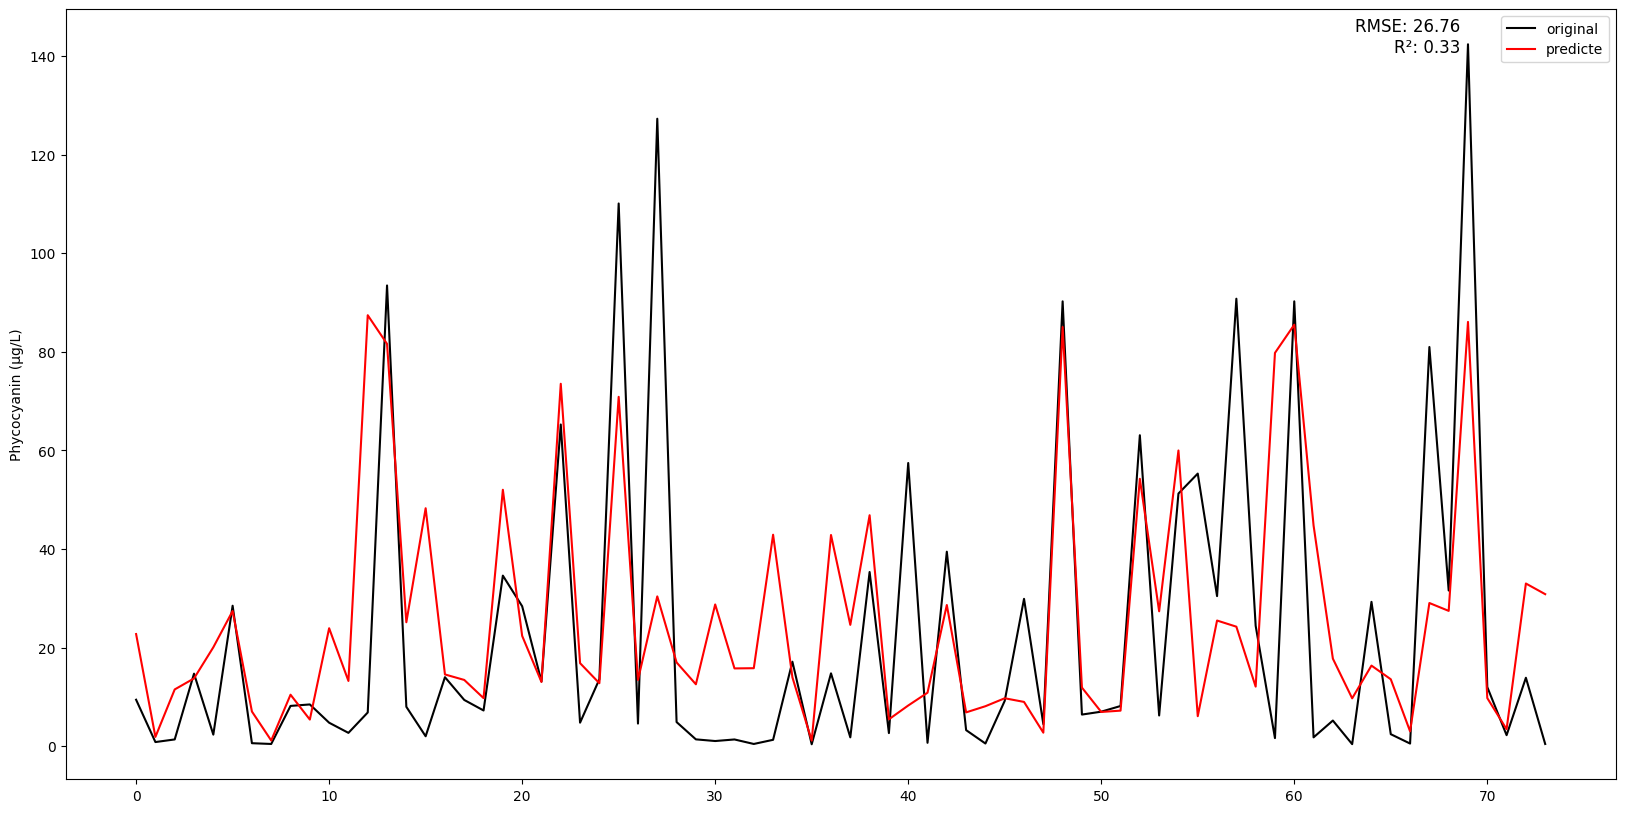

In [ ]:
X_train_pca, X_test_pca = PCAfunc(X_train, X_test)
RF_pred = RF(X_train_pca, Y_train, X_test_pca)

# Calcular o MSE
mse = mean_squared_error(Y_test, RF_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, RF_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, RF_pred)

Lasso

MSE: 493.14460028427845
R²: 0.5381012814111794


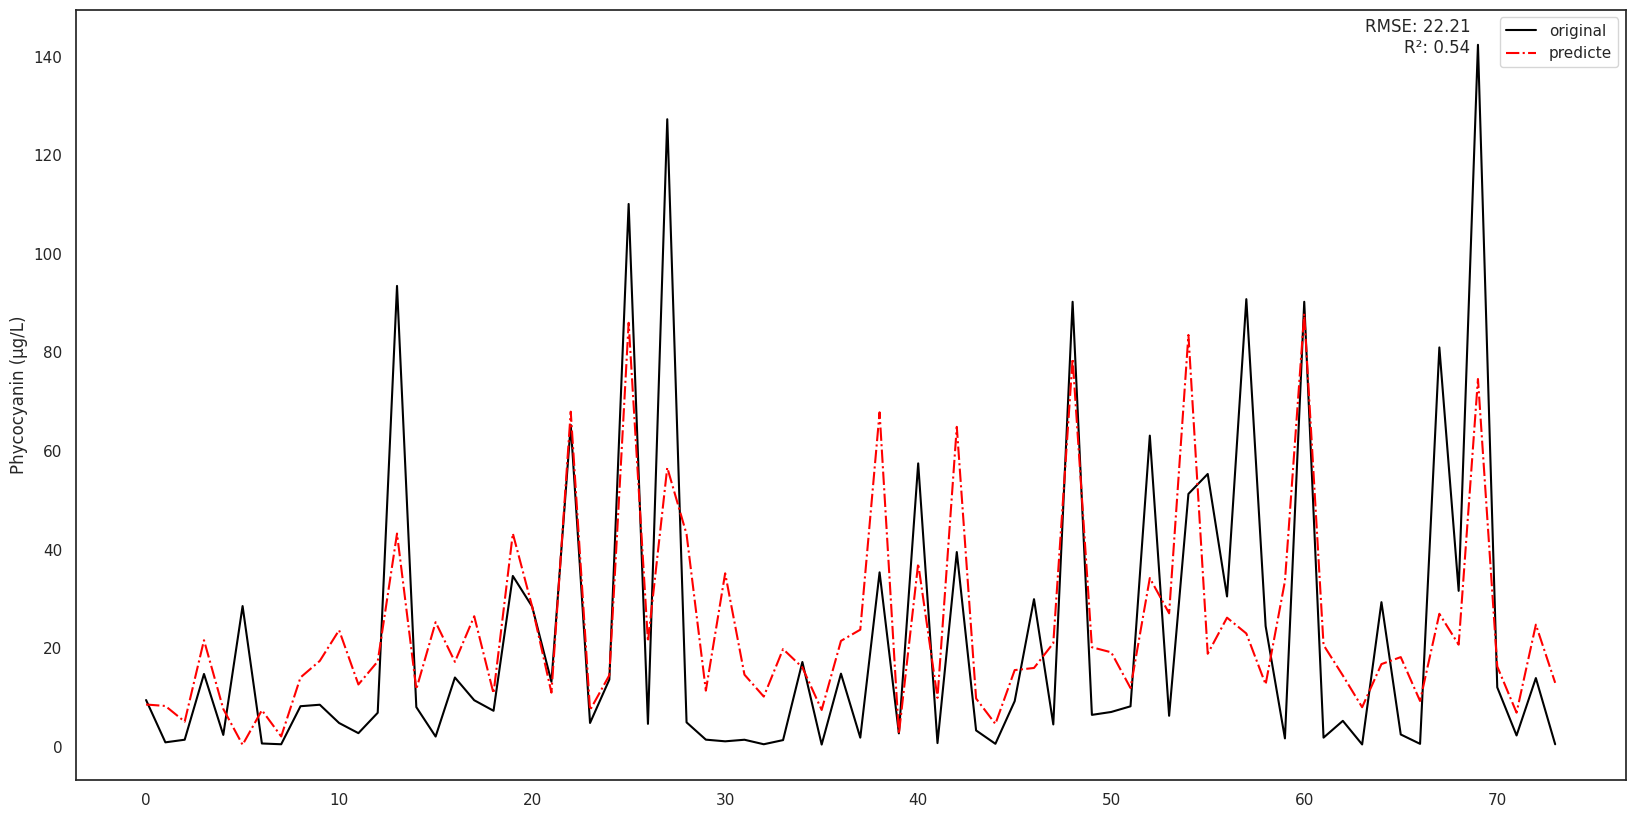

In [ ]:
lasso_pred = LASSO(X_train, Y_train, X_test)

# Calcular o MSE
mse = mean_squared_error(Y_test, lasso_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, lasso_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, lasso_pred)

PCA + LASSO

MSE: 624.4424754091373
R²: 0.41512250350578006


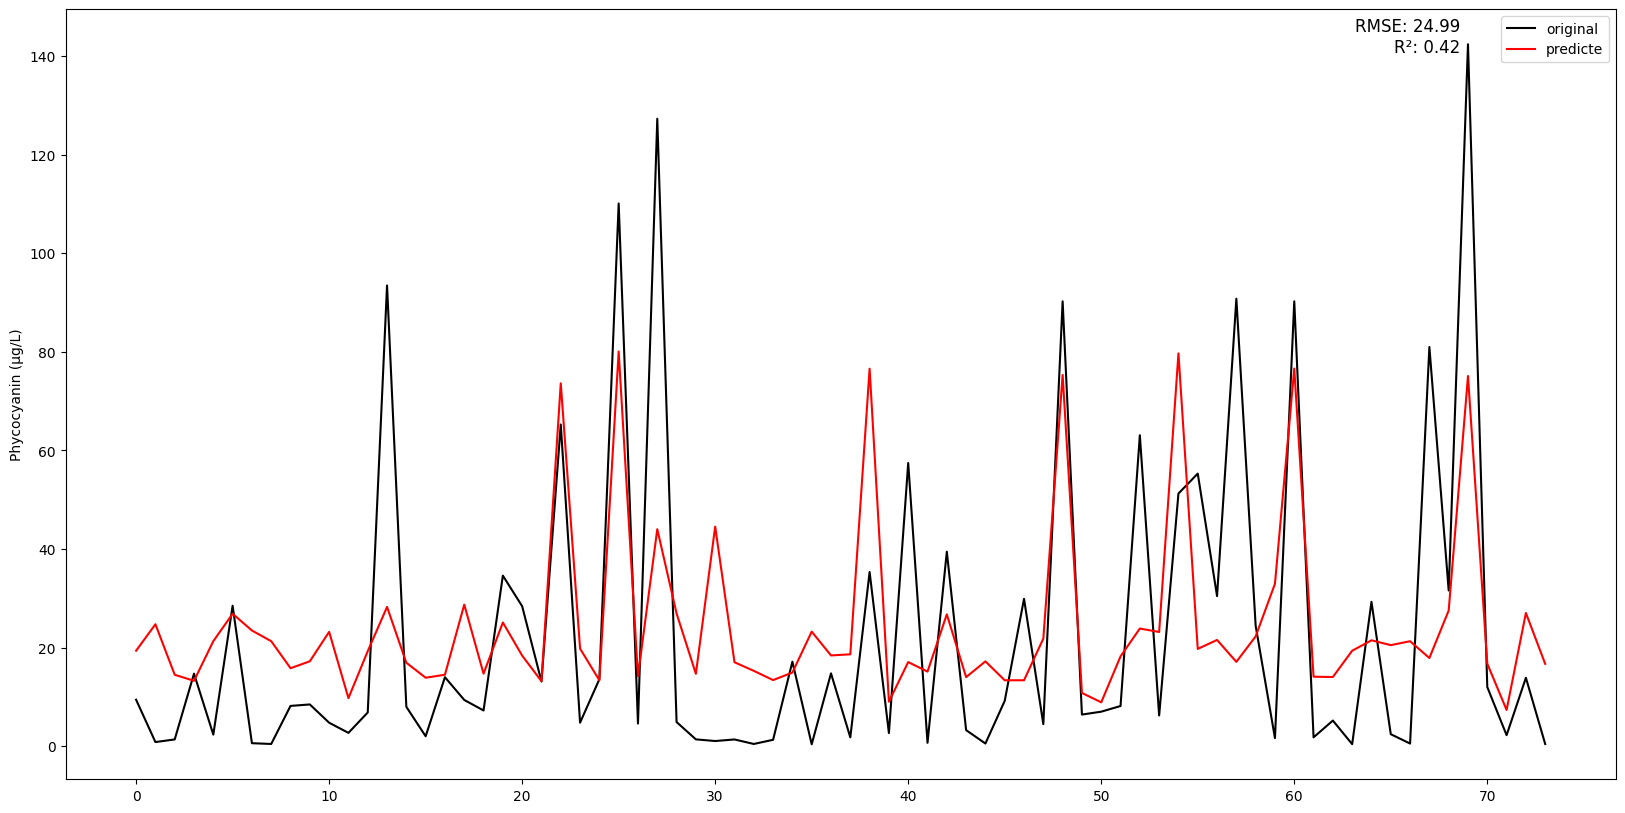

In [ ]:
X_train_pca, X_test_pca = PCAfunc(X_train, X_test)
lasso_pred = LASSO(X_train_pca, Y_train, X_test_pca)

# Calcular o MSE
mse = mean_squared_error(Y_test, lasso_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, lasso_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, lasso_pred)

Ridge Regression

MSE: 445.9373960590255
R²: 0.5823174142193566


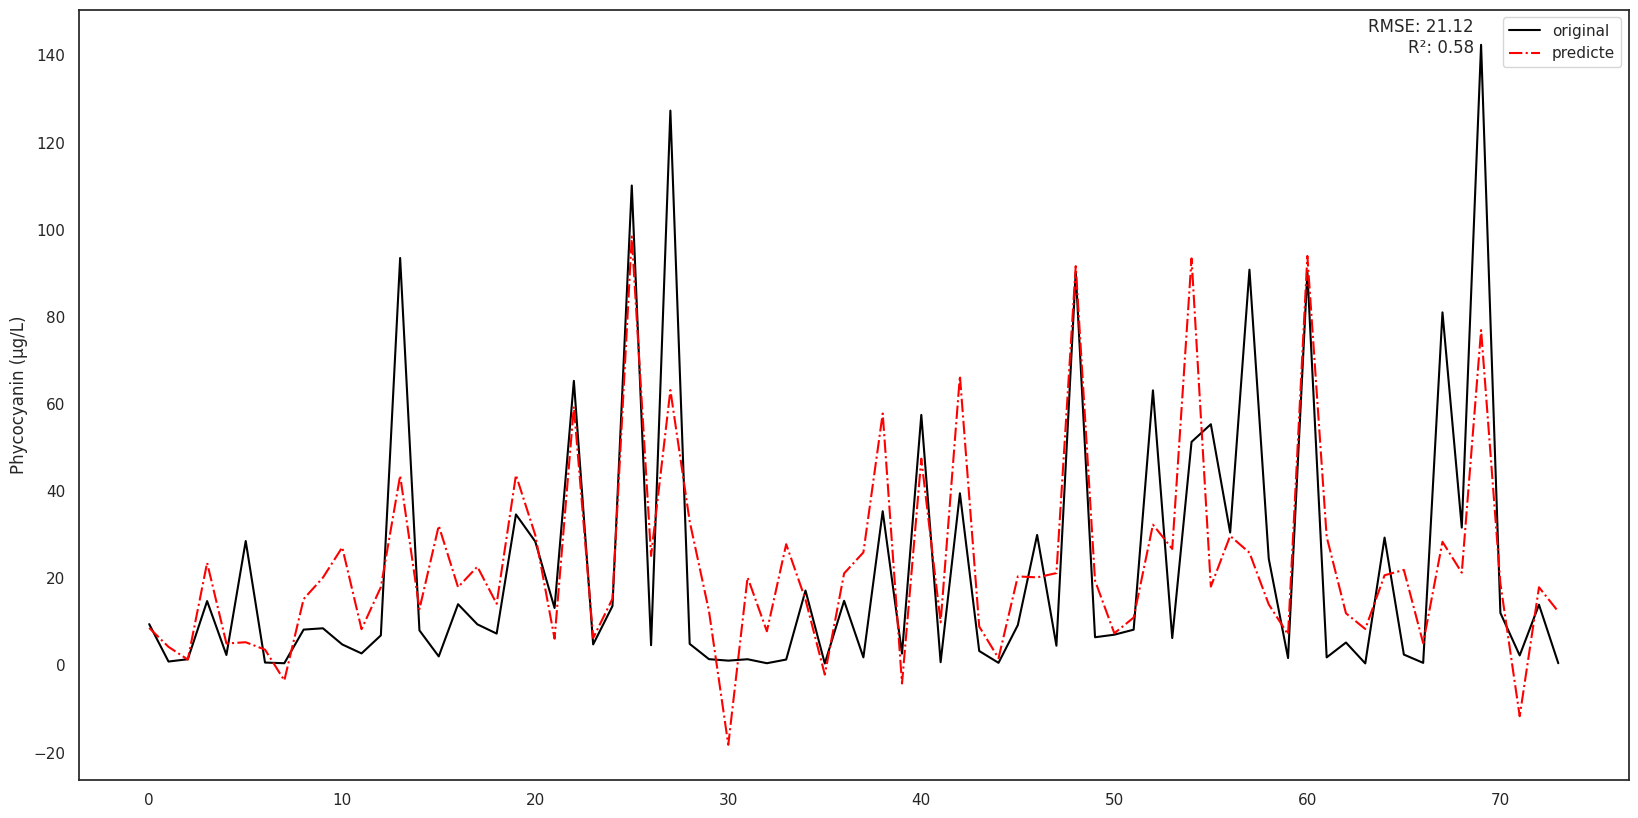

In [ ]:
ridge_pred = RIDGE(X_train, Y_train, X_test)

# Calcular o MSE
mse = mean_squared_error(Y_test, ridge_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, ridge_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, ridge_pred)

PCA + Ridge Regression

MSE: 619.1778551635838
R²: 0.42005355485233453


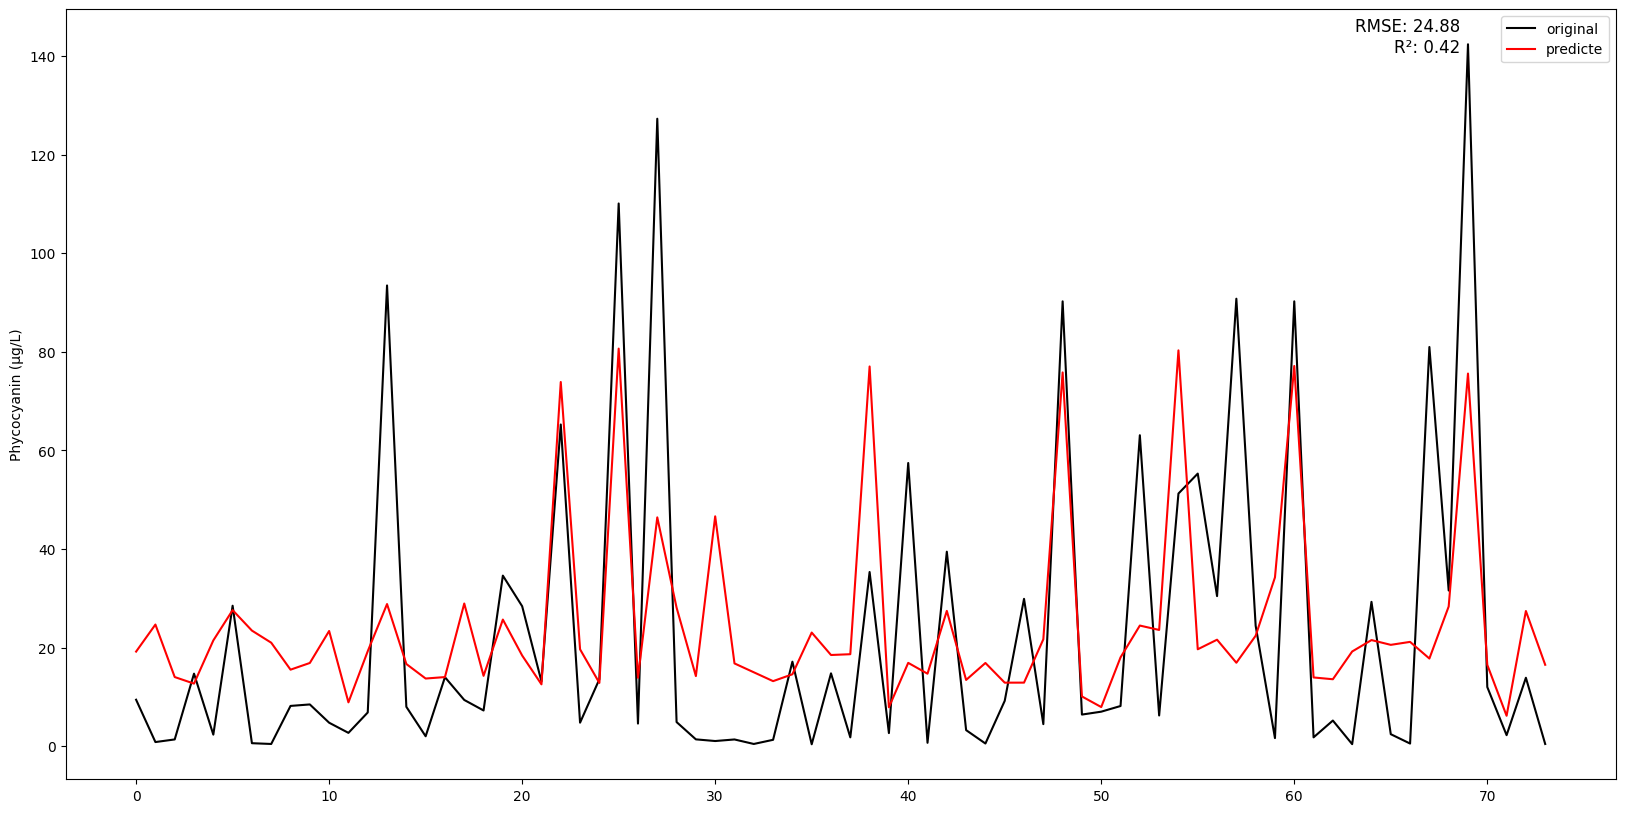

In [ ]:
X_train_pca, X_test_pca = PCAfunc(X_train, X_test)
ridge_pred = RIDGE(X_train_pca, Y_train, X_test_pca)

# Calcular o MSE
mse = mean_squared_error(Y_test, ridge_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, ridge_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, ridge_pred)

Support Vector Regression (SVR)

MSE: 717.4269420941264
R²: 0.32802957784928344


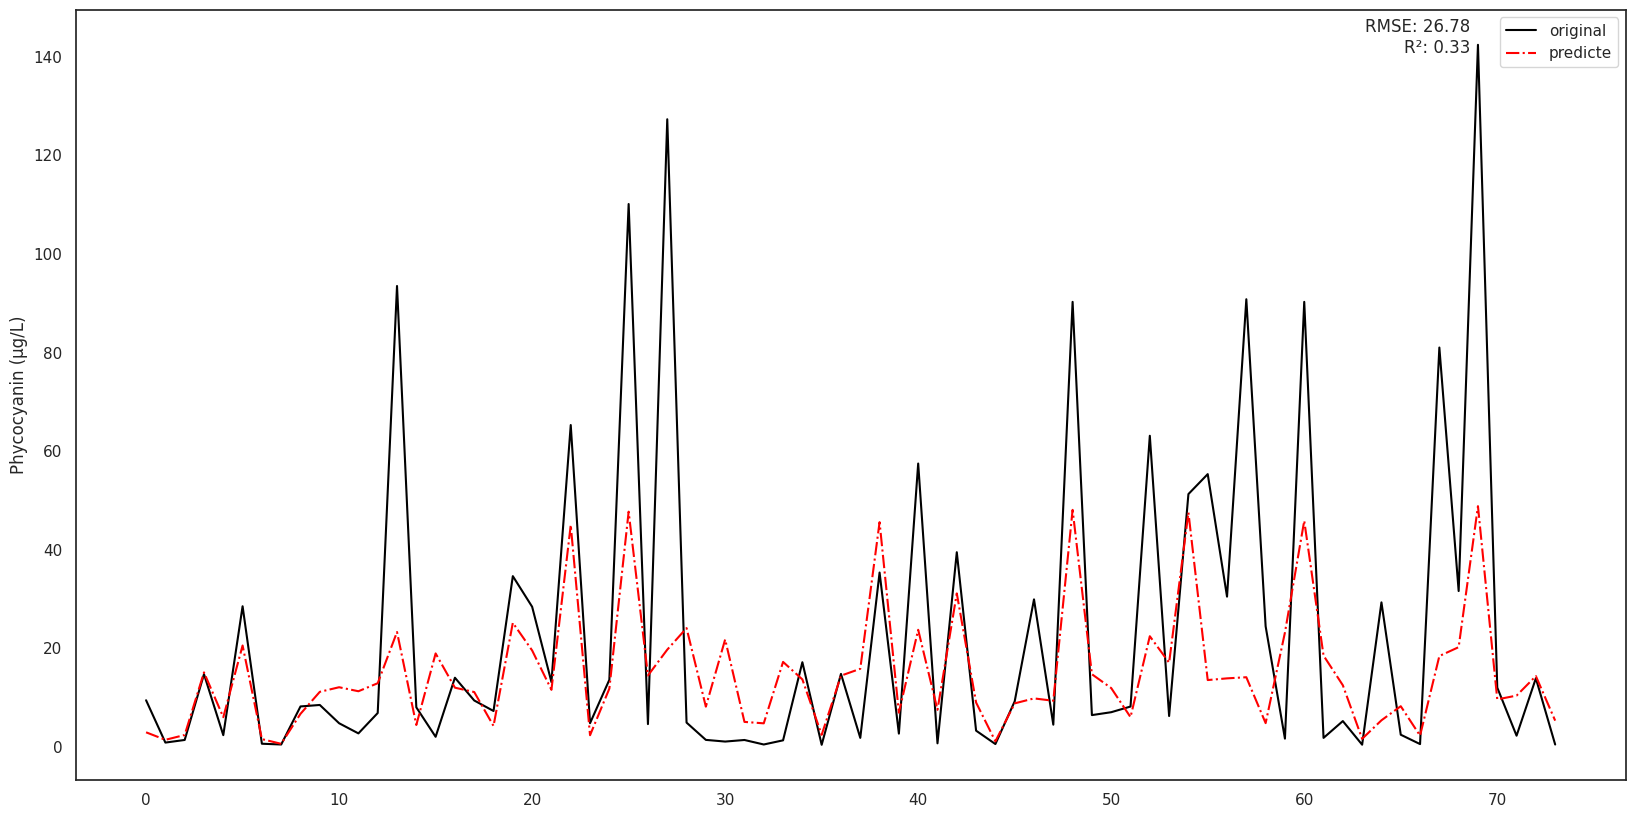

In [ ]:
SVR_pred = SVreg(X_train, Y_train, X_test)

# Calcular o MSE
mse = mean_squared_error(Y_test, SVR_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, SVR_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, SVR_pred)

PCA + Support Vector Regression

MSE: 729.4908236536056
R²: 0.3167300696922063


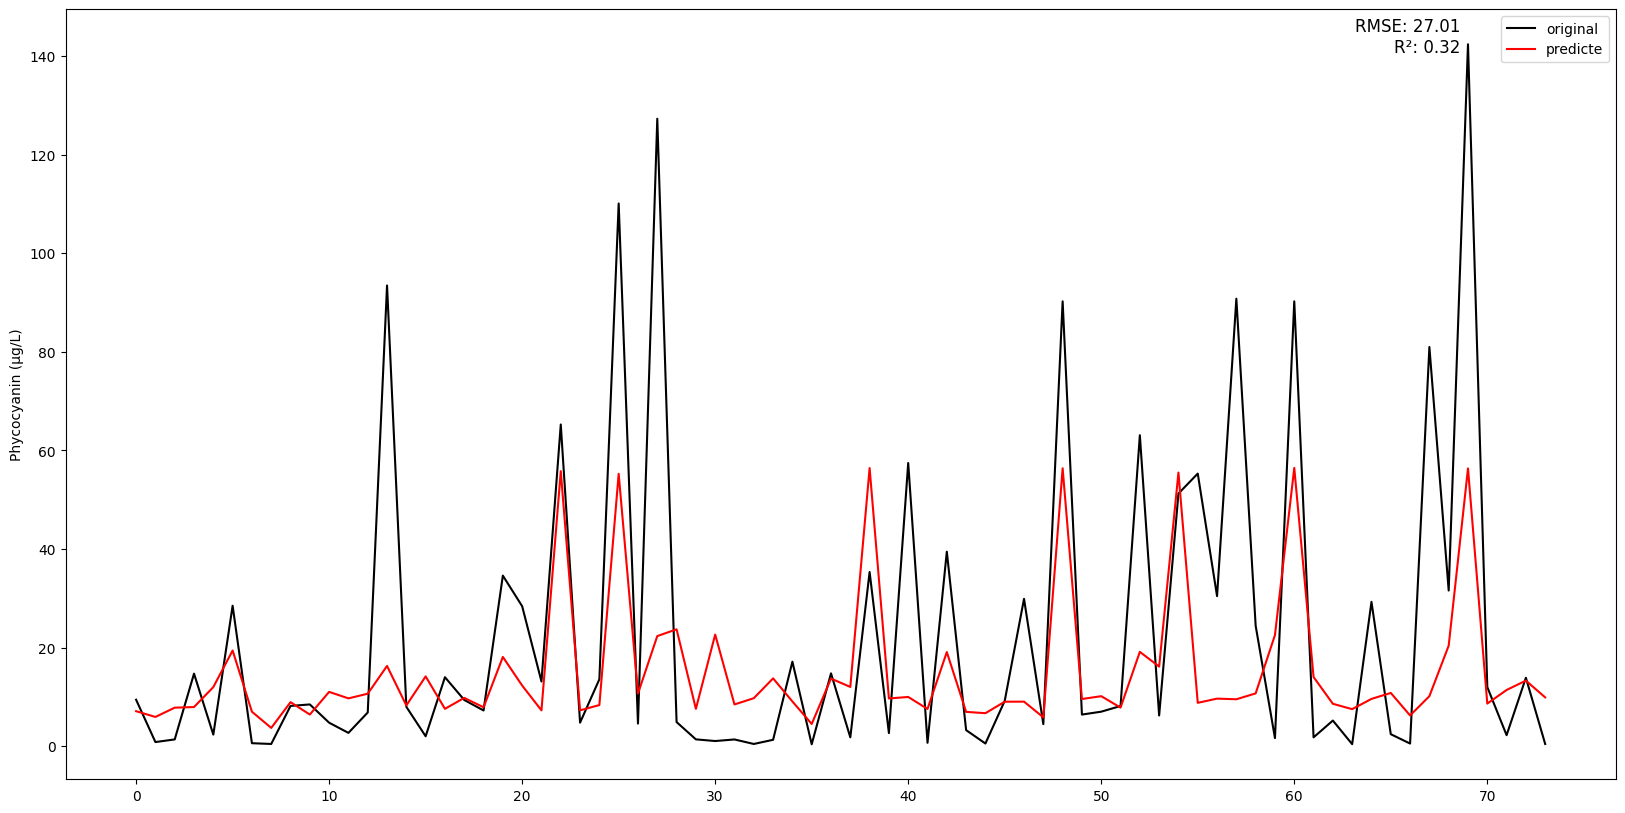

In [ ]:
X_train_pca, X_test_pca = PCAfunc(X_train, X_test)
SVR_pred = SVreg(X_train_pca, Y_train, X_test_pca)

# Calcular o MSE
mse = mean_squared_error(Y_test, SVR_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, SVR_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, SVR_pred)

 Nearest Neighbors Regression

MSE: 645.5380422391632
R²: 0.3953635620491023


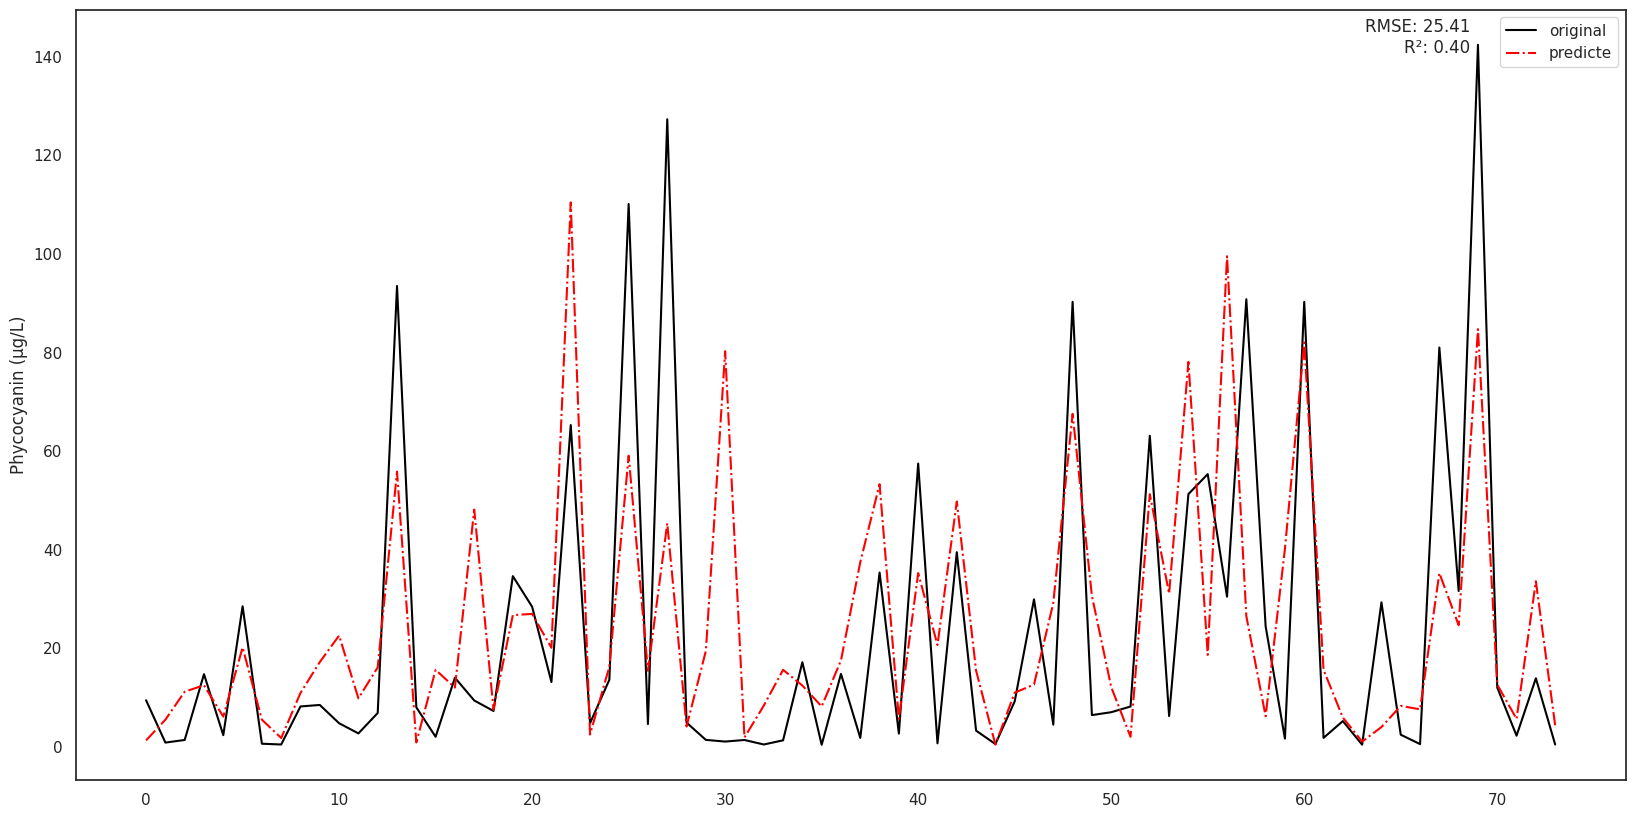

In [ ]:
knn_pred = KNN(X_train, Y_train, X_test)

# Calcular o MSE
mse = mean_squared_error(Y_test, knn_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, knn_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, knn_pred)

PCA + KNN

MSE: 770.6821557256324
R²: 0.27814864045204457


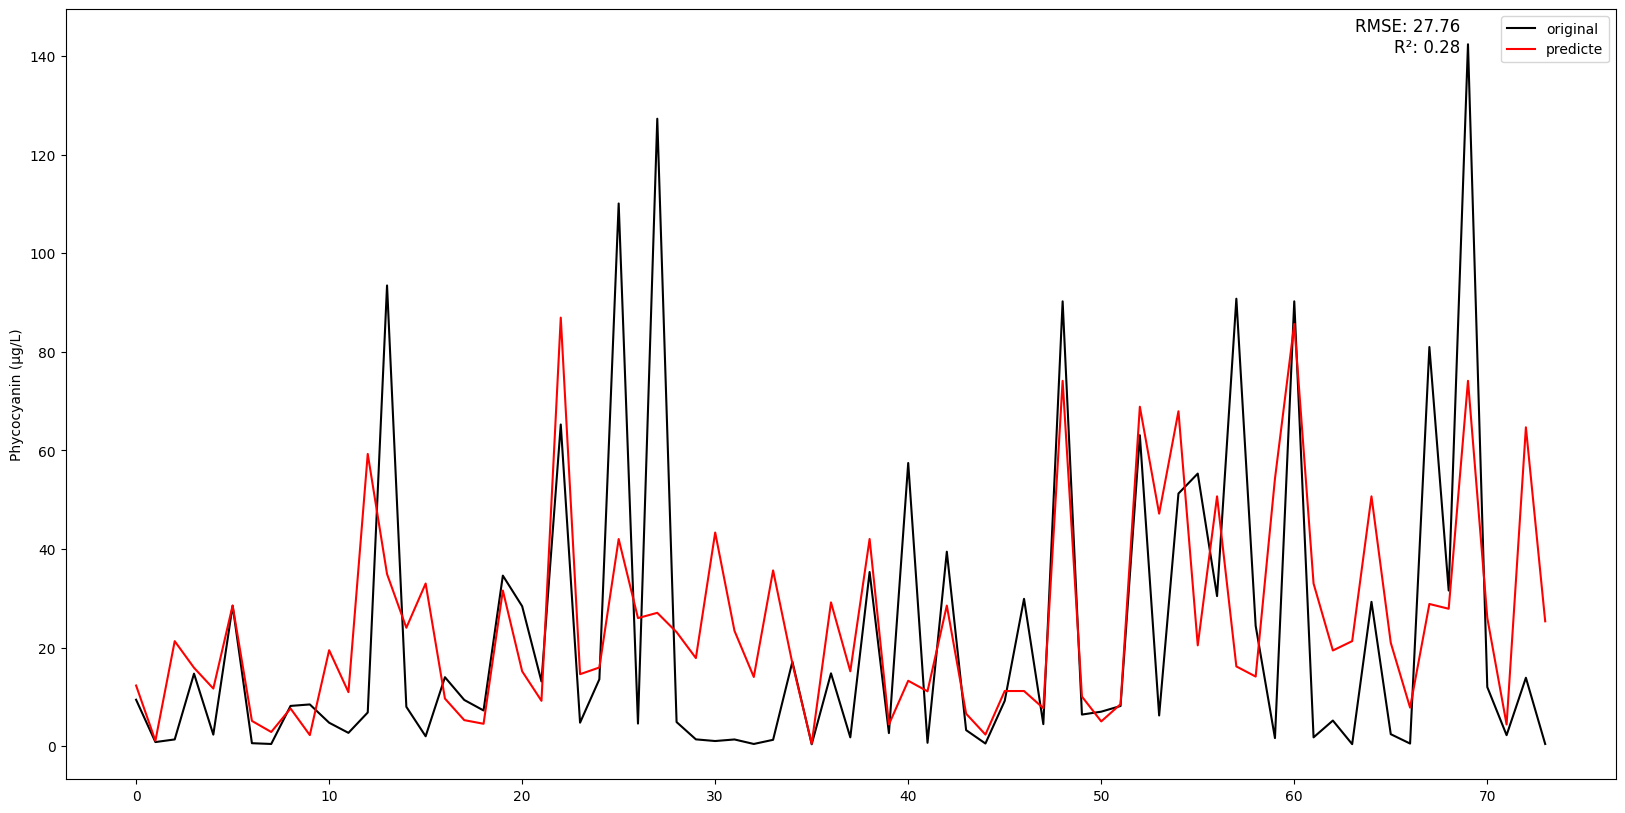

In [ ]:
X_train_pca, X_test_pca = PCAfunc(X_train, X_test)
knn_pred = KNN(X_train_pca, Y_train, X_test_pca)

# Calcular o MSE
mse = mean_squared_error(Y_test, knn_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, knn_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, knn_pred)

 Multi-layer Perceptron (MLP)

MSE: 609.6296832430619
R²: 0.428996749956595


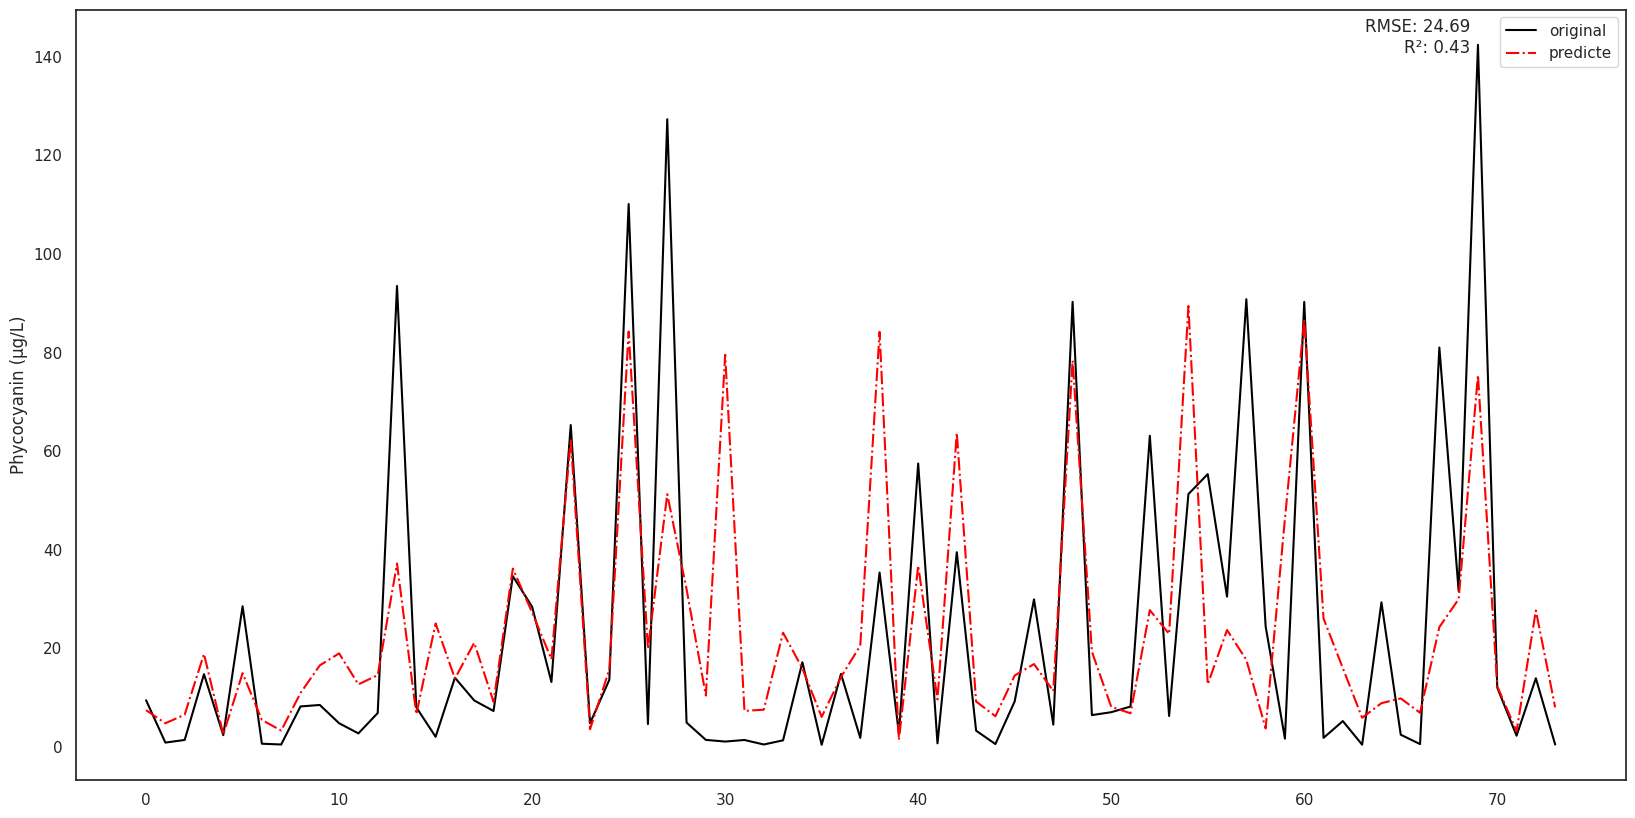

In [ ]:
mlp_pred = MLP(X_train, Y_train, X_test)

# Calcular o MSE
mse = mean_squared_error(Y_test, mlp_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, mlp_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, mlp_pred)

PCA + MLP

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MSE: 606.9298834594704
R²: 0.43152548911295696


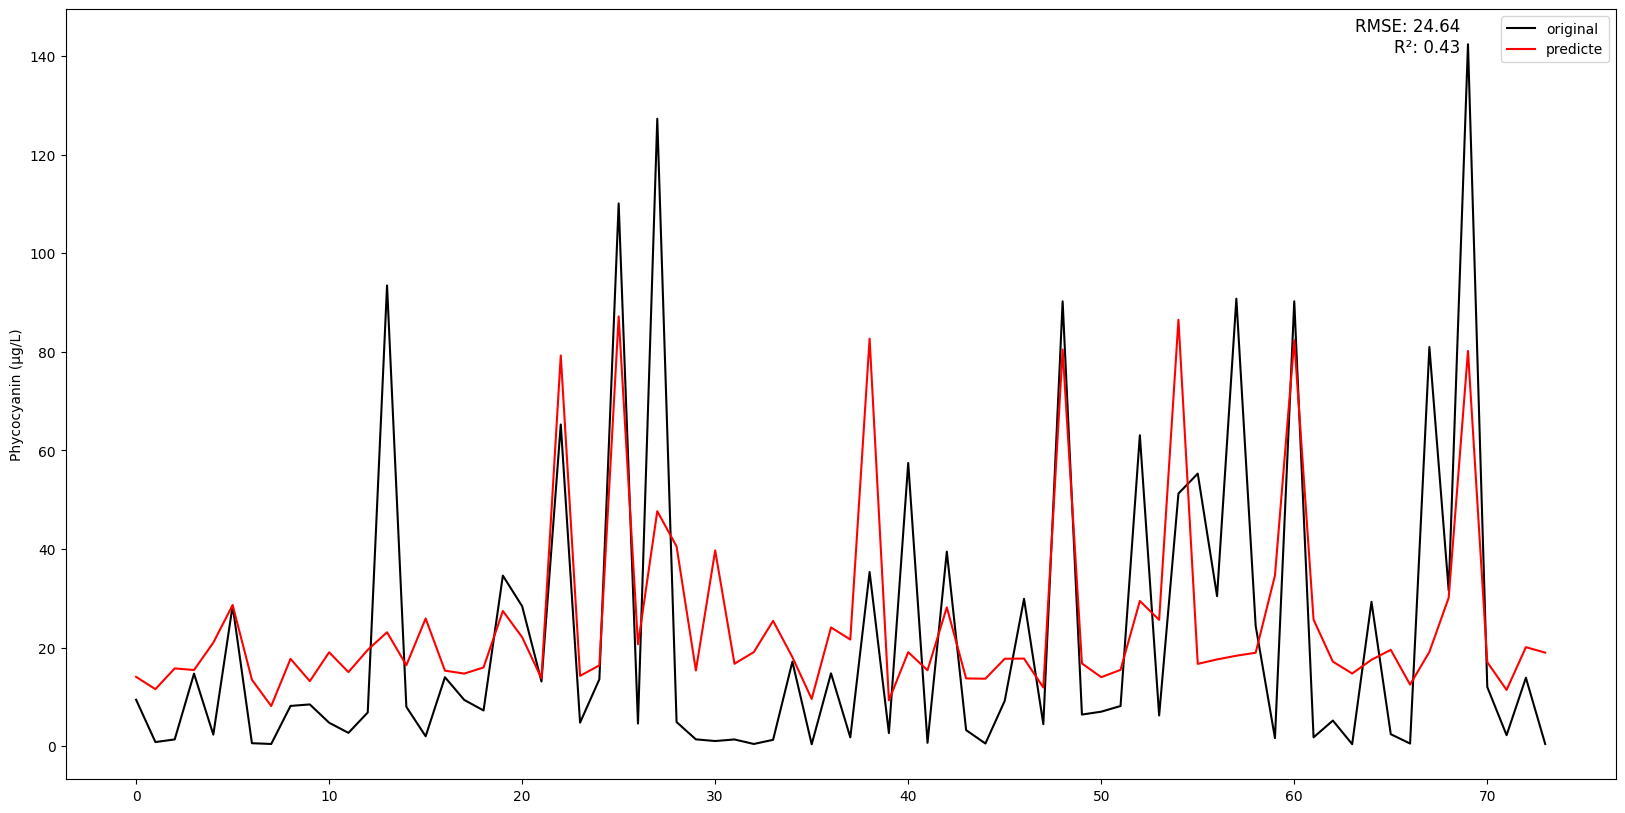

In [ ]:
X_train_pca, X_test_pca = PCAfunc(X_train, X_test)
mlp_pred = MLP(X_train_pca, Y_train, X_test_pca)

# Calcular o MSE
mse = mean_squared_error(Y_test, mlp_pred)
print("MSE:", mse)

# Calcular o coeficiente de determinação R²
r2 = r2_score(Y_test, mlp_pred)
print("R²:", r2)

plot_fig(X_test, Y_test, mlp_pred)

**Area selection for model application**

In [ ]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

**Area confirmation**

In [ ]:
roi=ee.FeatureCollection(Map.draw_features)
Map.addLayer(roi)

  **Image search parameters**

In [ ]:
cloud_cover = 1 #percentage value from 1 to 99
name_lake = 'General2'
#Range of the analyzed series
start_date = '2022-01-01' #the date is arranged 'yyyy-mm-dd'
end_date = '2023-07-24'   #the date is arranged 'yyyy-mm-dd'

**Image Selection**

In [ ]:
dataset = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                    .filterDate(start_date, end_date)\
                    .filterBounds(roi)\
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_cover))\
                    .map(iHP) \
                    .map(i2B) \
                    .map(i3B) \
                    .map(iE3B) \
                    .map(iNDCI) \
                    .map(iSLOPE) \
                    .map(iBG) \
                    .map(iRG) \
                    .map(i2BSubB) \
                    .map(i2BSubA) \
                    .map(i2BDivB) \
                    .map(i2BSubedge) \
                    .map(iSABI) \
                    .map(iFLH) \
                    .map(iNDPhyl) \
                    .map(iNDPhyledge) \
                    .map(iABDI) \
                    .map(iFAI) \
                    .map(iAFAI) \
                    .map(addDate)

listOfImages = dataset.toList(dataset.size())
number_images = dataset.size().getInfo()
print(f'The number of available images: {number_images}')

The number of available images: 1


**Function to create mask**

In [ ]:
def criarMascara(imagem, bandaDeInteresse, limiar):
  banda = imagem.select(bandaDeInteresse)
  mascara1 = banda.lte(limiar).selfMask()
  mascara2 = banda.gt(limiar).selfMask().multiply(-1).add(1)
  #mascara = ee.ImageCollection([mascara2, mascara1]).mosaic()
  mascara = mascara1.blend(mascara2)
  #mascara = mascara2.addBands(mascara1)
  return mascara


# Exemplo de uso da função para criar a máscara
bandaDeInteresse = 'mndwi'
img = ee.Image(listOfImages.get(0))
ndwi = img.normalizedDifference(["B3", "B6"]).rename("mndwi")
limiar = -0.1
mascara = criarMascara(ndwi, bandaDeInteresse, limiar)
mascara = mascara.clip(roi)
#mascaraInvertida = mascara.multiply(-1).add(1)

Map = geemap.Map()
Map.centerObject(roi, 11); #Centralizar o mapa na imagem GeoTIFF
Map.addLayer(mascara, {'palette': ['white', 'black'], 'min': 0, 'max': 1}, 'Máscara de Água')


geemap.ee_export_image(mascara, filename='/content/drive/MyDrive/mascara.tif', region=roi.geometry(), scale=30, file_per_band=False)
Map

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/mascara.tif


Map(center=[-4.087648296949834, -39.460058000001766], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
# Lista para armazenar imagens selecionadas
selected_images = []

# Função para lidar com a seleção de imagens
def on_image_selected(change, image):
    selected_images.append(image)
    print(f'Você selecionou a imagem com o ID: {image.get("system:index").getInfo()}')

# Função para remover a última imagem selecionada
def remove_last_image(change):
    if selected_images:
        removed_image = selected_images.pop()
        print(f'Imagem removida com o ID: {removed_image.get("system:index").getInfo()}')
    else:
        print('Nenhuma imagem para remover.')



for indx in range(0, number_images):
    img = ee.Image(listOfImages.get(indx))
    thumb = img.getThumbURL({
        'region': roi.geometry(),
        'scale': 50,
        'format': 'png',
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 600
    })
    image_ids = img.get('system:index').getInfo()
    dia = image_ids[6:8]
    mes = image_ids[4:6]
    ano = image_ids[:4]

    layout = widgets.Layout(width='auto')
    select_button = widgets.Button(description=f'Selecionar Imagem {indx}', layout=layout, display='flex')
    select_button.on_click(lambda change, img=img: on_image_selected(change, img))



    print(f'Imagem de {ano}-{mes}-{dia}')


    display(Image(url=thumb))
    display(select_button)

listaShow = [img.get("system:index").getInfo() for img in selected_images]
if listaShow:
  print("Imagens selecionadas:", [img.get("system:index").getInfo() for img in selected_images])

remove_button = widgets.Button(description='Remover Imagem', layout=layout, display='flex')
remove_button.on_click(remove_last_image)
display(remove_button)

In [ ]:
selected_images

**Training of the best model**

In [ ]:
gb_regressor = GradientBoostingRegressor()
gb_regressor.fit(X_train, Y_train)

GradientBoostingRegressor()

**Forecast image generation**

In [ ]:
image_dir = f'/content/drive/MyDrive/{name_lake}_PC/'
#if not os.path.exists(image_dir):
 # os.makedirs(image_dir)

image_dir2 = f'/content/drive/MyDrive/{name_lake}_PC/{name_lake}/'
if not os.path.exists(image_dir):
  os.makedirs(image_dir2)

band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '2B', '2BDivB', '2BSubA', '2BSubB', '2BSubedge', '3B', 'ABDI', 'AFAI', 'BG', 'E3B', 'FAI', 'FLH', 'HP', 'NDCI', 'NDPhyl', 'NDPhyledge', 'RG', 'SABI', 'SLOPE']
data = []
list_timedate = []
imageList = []
for indx in  range(0, len(selected_images)):
  try:
    img = selected_images[indx]
    ndwi = img.normalizedDifference(["B3", "B6"]).rename("mndwi")
    bandaDeInteresse = 'mndwi'
    limiar = -0.1
    mascara = criarMascara(ndwi, bandaDeInteresse, limiar)
    mascara = mascara.clip(roi.geometry())
    geemap.ee_export_image(mascara, filename='/content/drive/MyDrive/mascara.tif', region=roi.geometry(), scale=30, file_per_band=False, crs='EPSG:4326')
    timedate = img.get('GENERATION_TIME').getInfo()
    latlon = ee.Image.pixelLonLat().addBands(img)
    latlon = latlon.reduceRegion(reducer=ee.Reducer.toList(),\
      geometry=roi.geometry(), maxPixels=1e8, scale=30)

    #date
    image_ids = img.get('system:index').getInfo()
    dia = image_ids[6:8]
    mes = image_ids[4:6]
    ano = image_ids[:4]
    date = f'{ano}-{mes}-{dia}'

    for i in range(0, len(band_names)):
      data1 = np.array((ee.Array(latlon.get(band_names[i])).getInfo()))
      data.append(data1)
    lats = np.array((ee.Array(latlon.get('latitude')).getInfo()))
    lons = np.array((ee.Array(latlon.get('longitude')).getInfo()))

    #get unique lats and lons
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)
    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)
    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0]
    xs = uniqueLons[1] - uniqueLons[0]
    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols])
    arr.shape

    # fill the array with values
    counter =0
    list_latlons = []
    for y in range(0,len(arr)):
        #print('Lat', uniqueLats[y])
        for x in range(0,len(arr[0])):
            #print('Lon', uniqueLons[x])
            list_latlons.append(uniqueLats[y])
            list_latlons.append(uniqueLons[x])

    #valor de cada pixel com todas as bandas
    values_pixel = []
    for z in range(len(data[0])):
      list_bands = []
      for n in range(len(data)):
        list_bands.append(data[n][z])
      values_pixel.append(list_bands)
    len(values_pixel)

    #Realizando a previsão
    y_pred = gb_regressor.predict(values_pixel) #substituir pela função do melhor modelo
    arr = np.reshape(y_pred, (nrows, ncols))


    #Invertendo a posição da matriz
    arr1 = np.flip(arr, 0)
    print(arr1.shape)

    #Salvando o arquivo geotiff
    transform = (np.min(uniqueLons),xs,0,np.max(uniqueLats),0,-ys)
    print(transform)
    # set the coordinate system
    target = osr.SpatialReference()

    target.ImportFromEPSG(4326)
    #target.ImportFromEPSG(32724)

    # set driver
    driver = gdal.GetDriverByName('GTiff')

    outputDataset = driver.Create(f'{image_dir}{name_lake}_PC_{str(date)}.tif', ncols ,nrows, 1,gdal.GDT_Float32)
    print(outputDataset)
    # add some metadata
    print('indice:', indx)
    outputDataset.SetMetadata( {'time': str(timedate)} )
    outputDataset.SetGeoTransform(transform)
    outputDataset.SetProjection(target.ExportToWkt())
    outputDataset.GetRasterBand(1).WriteArray(arr1)
    outputDataset.FlushCache()
    outputDataset.GetRasterBand(1).SetNoDataValue(-9999)
    outputDataset = None

    #write geotiff
    # Caminho para o arquivo GeoTIFF
    path_geotiff = f'{image_dir}{name_lake}_PC_{str(date)}.tif'
    path_mask = f'/content/drive/MyDrive/mascara.tif'
    # Abrir o arquivo GeoTIFF com o rasterio
    with rasterio.open(path_geotiff) as src:
      banda_1 = src.read(1) # read data from first band
      transform = src.transform

    with rasterio.open(path_mask) as src:
      mascara_1 = src.read(1)     # read data from first band
    x, y = arr1.shape
    x1, y1 = mascara_1.shape
    if x1 > x:
      a = x - x1
    else:
      a = x

    if y1 > y:
      b = y - y1
    else:
      b = y

    mascara_1 = mascara_1[:a, :b]
    mascara_1[-1] = 1
    mascara_1 = ma.where(mascara_1==1, np.NaN, 0)
    mask = ma.masked_where(mascara_1==0, mascara_1)
    Image2_mask = ma.masked_array(banda_1,mask)
    raster_params = {
      'driver': 'GTiff',
      'width': mask.shape[1],
      'height': mask.shape[0],
      'count': 1,
      'dtype': 'float32',
      'compress': 'LZMA',
      'crs': {'init': 'epsg:4326'},
      'transform': transform
    }
    with rasterio.Env(GDAL_TIFF_INTERNAL_MASK=True):
      with rasterio.open(f'{image_dir2}{name_lake}_PC_{str(date)}.tif', 'w', **raster_params) as dataset:
          dataset.write(np.array([Image2_mask.astype('float32')]))
          dataset.write_mask(mask.mask)

  except Exception as e:
    print(f"Erro no processamento da imagem {indx}: {str(e)}")
    pass

  data = []
  list_latlons = []
  values_pixel = []
  list_bands = []
  print(date)


Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/mascara.tif
(232, 327)
(-39.50399852409064, 0.0002694945852397268, 0, -4.056567244262729, 0, -0.0002694945852361741)
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f822b3d5260> >
indice: 0
2022-10-05


In [ ]:
# Caminho para o arquivo GeoTIFF
#path_geotiff = f'{image_dir}{name_lake}_{str(date)}.tif'
path_geotiff = f'/content/drive/MyDrive/General/General_2022-08-06.tif'
path_mask = f'/content/drive/MyDrive/mascara.tif'
# Abrir o arquivo GeoTIFF com o rasterio
with rasterio.open(path_geotiff) as src:
    # Lê os dados da primeira banda
    banda_1 = src.read(1)
    transform = src.transform

with rasterio.open(path_mask) as src:
    # Lê os dados da primeira banda
    mascara_1 = src.read(1)

x, y = arr1.shape
x1, y1 = mascara_1.shape
if x1 > x:
  a = x - x1
else:
  a = x

if y1 > y:
  b = y - y1
else:
  b = y

mascara_1 = mascara_1[:a, :b]
mascara_1[-1] = 1
infor = roi.geometry().getInfo()
lon = round(infor['coordinates'][0][0][0], 4)
lat = round(infor['coordinates'][0][0][1], 4)
lon1 = round(infor['coordinates'][0][2][0], 4)
lat1 = round(infor['coordinates'][0][2][1], 4)

region = [lon, lat, lon1, lat1]

A=[lon*np.pi/180.,lat*np.pi/180.] #Known latitude and longitude
B=[(lon+1)*np.pi/180.,lat*np.pi/180.] #Known longitude +1
#dx=(6371000)*haversine_distances([A,B])[0,1]



print("Shape da máscara:", mascara_1.shape)
print("Shape da imagem:", banda_1.shape)

mascara_1 = ma.where(mascara_1==1, np.NaN, 0)

mask = ma.masked_where(mascara_1==0, mascara_1)
x, y = banda_1.shape
#mask = np.reshape(mask, (x,y))
print("Shape da imagem:", mask.shape)
Image2_mask = ma.masked_array(banda_1,mask)


raster_params = {
    'driver': 'GTiff',
    'width': mask.shape[1],
    'height': mask.shape[0],
    'count': 1,
    'dtype': 'float32',
    'compress': 'LZMA',
    'crs': {'init': 'epsg:4326'},
    'transform': transform
}


"""with rasterio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    with rasterio.open('/content/drive/MyDrive/raster.tif', 'w', **raster_params) as dataset:
        dataset.write(Image2_mask.astype('float32'), 1)  # just write correctly masked array"""

with rasterio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    with rasterio.open('/content/drive/MyDrive/raster.tif', 'w', **raster_params) as dataset:
        dataset.write(np.array([Image2_mask.astype('float32')]))
        dataset.write_mask(mask.mask)

# Plotar a imagem usando matplotlib
fig  = plt.figure(figsize=(16, 13))

cmap = plt.cm.get_cmap('jet')
plt.imshow(Image2_mask, extent=region, cmap=cmap)
plt.show()

